# Capstone Project - The Battle of the Neighborhoods (Week 2)

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location and rating for a restaurant . Specifically, this report will be targeted to stakeholders interested in opening any type of **Restaurant** in **Bangalore**, India.

Since there are lots of restaurants in Bangalore we will try to detect **Neighborhoods** which have a high ratings of restaurant, specifically high rating in the category of reatsurants selected by stakeholder. Also we will look for **Neighborhoods** where people spend more money on food as this will give oppurtunity to stakeholders to earn more. We will take the distance from center also into consideration, keeping in mind above both conditions are met.So we will focus only on neighborhoods which are within 10kms from the center. Also we will predict **Rating** of the restaurant at top 5 preferred location. 

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* Number of existing restaurants in the neighborhood (any type of restaurant)
* Number of Specific type of restaurant in the neighborhood, if any
* Rating of all restaurants 
* Average pricing for 2 people in all restaurants
* Cuisines offered at the restaurants
* And distance of neighborhood from city center



Following data sources will be needed to extract/generate the required information:
* Pincodes of neighborhoods in Bangalore city through a csv downloaded from        
**https://github.com/sanand0/pincode/blob/master/data/IN.csv**
* Centers of neighborhoods will be obtained from **Google Maps API geocoding**
* Bangalore center will also be obatined from **Google Maps API geocoding**
* number of restaurants and their type and location in every neighborhood(within 10kms form Bangalore center) will be obtained using **Foursquare API**
* Restaurant Rating,Average cost for 2 people, table booking option, online order option, Restaurant type and restaurant Cuisines will be obtained from **Zomato Developer API**

### Neighborhood Candidates

Let's download and pincodes of India from github link and store it in a dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import requests

In [2]:
pd.set_option('display.max_columns',None) #Displaying all columns of a dataframe
pd.set_option('display.max_rows',None)  #Displaying all rows of a dataframe

In [3]:
df_pincodes=pd.read_csv('indiapincodes.csv')
df_pincodes.head()

Country  Pincode  Neighborhood           City  Latitude  Longitude
0      IN   744101  Marine Jetty  South Andaman   11.6667    92.7500
1      IN   744101    Port Blair  South Andaman   11.6667    92.7500
2      IN   744101  N.S.Building  South Andaman   11.6667    92.7500
3      IN   744102         Haddo  South Andaman   11.6833    92.7167
4      IN   744102       Chatham  South Andaman   11.7000    92.6667

As we see, the file contains pincodes of all the cities in India. We are only interested in "bangalore", so we will filter out the dataframe and store data, which have **Bangalore** keyword in city column.

In [4]:
df_blr_pc=df_pincodes[df_pincodes['City'].str.contains("Bangalore")]
df_blr_pc.head()

Country  Pincode         Neighborhood       City  Latitude  Longitude
50019      IN   560001     Bangalore G.P.O.  Bangalore   12.9914    77.5944
50020      IN   560001     Legislators Home  Bangalore   12.9914    77.5944
50021      IN   560001        Vasanthanagar  Bangalore   12.9914    77.5944
50022      IN   560001  Mahatma Gandhi Road  Bangalore   12.9914    77.5944
50023      IN   560001       Vidhana Soudha  Bangalore   12.9914    77.5944

In [5]:
df_blr_pc['Neighborhood'].value_counts()

Kannamangala                       3
Kodigehalli                        3
Mahadevapura                       2
Mallathahalli                      2
Huskur                             2
Herohalli                          2
Shivanapura                        2
Byatarayanapura                    2
Tavarekere                         2
Begur                              2
Mayasandra                         2
Rv Niketan                         1
Korati                             1
Hullegowdanahalli                  1
Sakkaaregollahalli                 1
West of Chord Road II stage        1
Thambuchetty palya                 1
Kumaraswamy Layout                 1
Hampinagar                         1
Narasandra                         1
Heggadahalli                       1
New Thippasandra                   1
Hoodi                              1
Kudur                              1
Yelachenahalli                     1
Aluru                              1
Jalahalli                          1
U

As we see, 1 neighborhood have more than 1 pincode, so we will ignore the pincode column and work with unique neighborhood only. Also country in the dataframe is not required, so we will drop that column as well.

In [6]:

df_blr_nd=df_blr_pc.drop(['Country','Pincode'],axis=1)

df_blr_nd.head()

Neighborhood       City  Latitude  Longitude
50019     Bangalore G.P.O.  Bangalore   12.9914    77.5944
50020     Legislators Home  Bangalore   12.9914    77.5944
50021        Vasanthanagar  Bangalore   12.9914    77.5944
50022  Mahatma Gandhi Road  Bangalore   12.9914    77.5944
50023       Vidhana Soudha  Bangalore   12.9914    77.5944

Now we will get the **unique neighborhood** from the dataframe

In [7]:
df_blr_nd.drop_duplicates(subset='Neighborhood',inplace=True)
df_blr_nd.reset_index(drop=True,inplace=True)

In [8]:
df_blr_nd.head()

Neighborhood       City  Latitude  Longitude
0     Bangalore G.P.O.  Bangalore   12.9914    77.5944
1     Legislators Home  Bangalore   12.9914    77.5944
2        Vasanthanagar  Bangalore   12.9914    77.5944
3  Mahatma Gandhi Road  Bangalore   12.9914    77.5944
4       Vidhana Soudha  Bangalore   12.9914    77.5944

In [9]:
df_blr_nd.shape

(455, 4)

As Latitude and Longitude were against pincodes from the pincodes file, we cant use them. So we will use **Google API** to get center of each neighborhood. For that first we will merge **Neighborhood column and City to a new column Address**, as Neighborhood name can be same in other cities as well.

In [10]:
# adding address column for google api
df_blr_nd['address']=df_blr_nd['Neighborhood']+","+df_blr_nd['City']
df_blr_nd.head()

Neighborhood       City  Latitude  Longitude  \
0     Bangalore G.P.O.  Bangalore   12.9914    77.5944   
1     Legislators Home  Bangalore   12.9914    77.5944   
2        Vasanthanagar  Bangalore   12.9914    77.5944   
3  Mahatma Gandhi Road  Bangalore   12.9914    77.5944   
4       Vidhana Soudha  Bangalore   12.9914    77.5944   

                         address  
0     Bangalore G.P.O.,Bangalore  
1     Legislators Home,Bangalore  
2        Vasanthanagar,Bangalore  
3  Mahatma Gandhi Road,Bangalore  
4       Vidhana Soudha,Bangalore

#### THE GOOGLE API

In [42]:
google_api_key='' # hidden because of security reasons


In [30]:
# defining a function for getting cordinates
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]

In [36]:
# Calling the get_coordinates function according to data in df_blr_nd

x=0
df_blr_nd['latitude']=0
df_blr_nd['longitude']=0
for address in df_blr_nd['address']:
    Address=get_coordinates(google_api_key,address)
    df_blr_nd['latitude'].loc[x]=Address[0]
    df_blr_nd['longitude'].loc[x]=Address[1]
    print('Coordinate of {}: {}'.format(address, Address))
    x=x+1
    
    
    
    

Coordinate of Bangalore G.P.O.,Bangalore: [12.9812201, 77.59506929999999]
Coordinate of Legislators Home,Bangalore: [12.982845, 77.589609]
Coordinate of Vasanthanagar,Bangalore: [12.9896194, 77.5927948]
Coordinate of Mahatma Gandhi Road,Bangalore: [12.9747066, 77.6094093]
Coordinate of Vidhana Soudha,Bangalore: [12.9796734, 77.5912443]
Coordinate of Rajbhavan (Bangalore),Bangalore: [12.9824669, 77.5913035]
Coordinate of HighCourt,Bangalore: [12.9778739, 77.592635]
Coordinate of Cubban Road,Bangalore: [12.9780695, 77.6057847]
Coordinate of Bangalore Bazaar,Bangalore: [12.9287983, 77.67638149999999]
Coordinate of CMM Court Complex,Bangalore: [12.9731267, 77.5831511]
Coordinate of Dr. Ambedkar Veedhi,Bangalore: [12.9797021, 77.59254709999999]
Coordinate of Bangalore City,Bangalore: [12.9715987, 77.5945627]
Coordinate of Bangalore Corporation Building,Bangalore: [12.9607769, 77.58423719999999]
Coordinate of Sri Jayachamarajendra Road,Bangalore: [12.9772164, 77.58594579999999]
Coordinate of

Coordinate of Peenya Small Industries,Bangalore: [13.0181352, 77.50691259999999]
Coordinate of Peenya I Stage,Bangalore: [13.0345565, 77.52620089999999]
Coordinate of Laggere,Bangalore: [13.0097647, 77.5253962]
Coordinate of Peenya II Stage,Bangalore: [13.0143279, 77.4879411]
Coordinate of Rv Niketan,Bangalore: [12.9241169, 77.5049042]
Coordinate of Chudenapura,Bangalore: [12.9715987, 77.5945627]
Coordinate of Kengeri,Bangalore Rural: [12.8996676, 77.4826837]
Coordinate of Kengeri Upanagara,Bangalore Rural: [12.9386704, 77.4791599]
Coordinate of Sulikere,Bangalore Rural: [12.9500673, 77.459441]
Coordinate of Subramanyapura,Bangalore: [12.8964518, 77.54067169999999]
Coordinate of Chikkalasandra,Bangalore: [12.9120815, 77.5462476]
Coordinate of Doddakallasandra,Bangalore: [12.8806617, 77.55758039999999]
Coordinate of Konanakunte,Bangalore: [12.8822193, 77.5659682]
Coordinate of Tataguni,Bangalore: [12.8432153, 77.5117782]
Coordinate of A F Station Yelahanka,Bangalore: [13.1372433, 77.610

Coordinate of Hebbagodi,Bangalore: [12.8257264, 77.6780035]
Coordinate of Muthanallur,Bangalore: [12.8318119, 77.73500059999999]
Coordinate of Huskur,Bangalore Rural: [13.2719532, 77.46446069999999]
Coordinate of Electronics City,Bangalore: [12.8452145, 77.6601695]
Coordinate of Wipro Limited,Bangalore: [12.8384639, 77.6562719]
Coordinate of HSR Layout,Bangalore: [12.9121181, 77.6445548]
Coordinate of Bellandur,Bangalore: [12.9304278, 77.678404]
Coordinate of Panathur,Bangalore: [12.9355734, 77.7057495]
Coordinate of Hampinagar,Bangalore: [12.9623808, 77.5365585]
Coordinate of Kallubalu,Bangalore: [12.771693, 77.6237908]
Coordinate of Jigani,Bangalore: [12.7791043, 77.64359790000002]
Coordinate of Hennagara,Bangalore: [12.7889092, 77.6750869]
Coordinate of Hulimangala,Bangalore: [12.8288154, 77.6405575]
Coordinate of Haragadde,Bangalore: [12.7637802, 77.65074890000001]
Coordinate of Achitnagar,Bangalore Rural: [13.0900634, 77.4855548]
Coordinate of Anjanapura,Bangalore: [12.8616517, 77

Coordinate of Nandagudi,Bangalore Rural: [13.2047902, 77.9031754]
Coordinate of Nelavagilu,Bangalore Rural: [13.2332728, 77.9210307]
Coordinate of Bylanarasapura,Bangalore Rural: [13.1780177, 77.9365424]
Coordinate of Hindaganala,Bangalore Rural: [13.2270592, 77.9096036]
Coordinate of Nelamangala,Bangalore Rural: [13.097301, 77.38563979999999]
Coordinate of Mylanahalli,Bangalore Rural: [13.1300388, 77.3984704]
Coordinate of Arasinakunte,Bangalore Rural: [13.0795427, 77.3920128]
Coordinate of Jakkanahalli,Bangalore Rural: [13.1783749, 77.3467996]
Coordinate of Yentiganahalli,Bangalore Rural: [13.0619287, 77.34606219999999]
Coordinate of Budihal,Bangalore Rural: [13.1312296, 77.35889259999999]
Coordinate of Teppadabeguru,Bangalore Rural: [13.2846993, 77.6077865]
Coordinate of Mallarabanavadi,Bangalore Rural: [13.0738846, 77.37923359999999]
Coordinate of Dasanapaura,Bangalore Rural: [13.0700786, 77.4291142]
Coordinate of Gollahalli,Bangalore Rural: [13.1515617, 77.7250734]
Coordinate of H

In [38]:
#copying the data iin new database
df_blr=df_blr_nd.copy()

In [39]:
df_blr

Neighborhood             City  Latitude  Longitude  \
0                   Bangalore G.P.O.        Bangalore   12.9914    77.5944   
1                   Legislators Home        Bangalore   12.9914    77.5944   
2                      Vasanthanagar        Bangalore   12.9914    77.5944   
3                Mahatma Gandhi Road        Bangalore   12.9914    77.5944   
4                     Vidhana Soudha        Bangalore   12.9914    77.5944   
5              Rajbhavan (Bangalore)        Bangalore   12.9914    77.5944   
6                          HighCourt        Bangalore   12.9914    77.5944   
7                        Cubban Road        Bangalore   12.9914    77.5944   
8                   Bangalore Bazaar        Bangalore   12.9914    77.5944   
9                  CMM Court Complex        Bangalore   12.9914    77.5944   
10               Dr. Ambedkar Veedhi        Bangalore   12.9914    77.5944   
11                    Bangalore City        Bangalore   12.9719    77.5937   
12    Bangalore Corporation Building        Bangalore   12.9719    77.5937   
13        Sri Jayachamarajendra Road        Bangalore   12.9719    77.5937   
14                 Palace Guttahalli        Bangalore   13.0097    77.5648   
15                       Malleswaram        Bangalore   13.0097    77.5648   
16                Swimming Pool Extn        Bangalore   13.0097    77.5648   
17                   Vyalikaval Extn        Bangalore   13.0097    77.5648   
18                Pampamahakavi Road        Bangalore   13.5207    76.0303   
19                    Thyagarajnagar        Bangalore   13.5207    76.0303   
20                           Mavalli        Bangalore   14.0998    74.4891   
21                      Basavanagudi        Bangalore   12.9417    77.5714   
22                       Fraser Town        Bangalore   13.2029    76.9627   
23                         J.C.Nagar        Bangalore   13.2029    76.9627   
24              Training Command IAF        Bangalore   13.2029    76.9627   
25                             Agram        Bangalore   13.2029    76.9627   
26                Air Force Hospital        Bangalore   13.2029    76.9627   
27                     Hulsur Bazaar        Bangalore   13.2029    76.9627   
28                    H.A.L II Stage        Bangalore   13.2029    76.9627   
29                        K. G. Road        Bangalore   13.2029    76.9627   
30       Bangalore Dist Offices Bldg        Bangalore   13.2029    76.9627   
31                       Rajajinagar        Bangalore   12.9847    77.5491   
32     Industrial Estate (Bangalore)        Bangalore   12.9847    77.5491   
33            Rajajinagar IVth Block        Bangalore   12.9847    77.5491   
34                Jayangar III Block        Bangalore   15.8266    76.2752   
35                     Madhavan Park        Bangalore   15.8266    76.2752   
36                 Science Institute        Bangalore   15.8266    76.2752   
37                         Jalahalli        Bangalore   13.0448    77.5474   
38                    Jalahalli East        Bangalore   15.8266    76.2752   
39                    Jalahalli West        Bangalore   15.8266    76.2752   
40              Krishnarajapuram R S        Bangalore   15.8266    76.2752   
41                     Doorvaninagar        Bangalore   15.8266    76.2752   
42                  Ramamurthy Nagar        Bangalore   15.8266    76.2752   
43                        Vimanapura        Bangalore   21.4504    73.7291   
44                               NAL        Bangalore   21.4504    73.7291   
45            Chamrajpet (Bangalore)        Bangalore   15.8266    76.2752   
46              Gaviopuram Extension        Bangalore   15.8266    76.2752   
47                     Seshadripuram        Bangalore   12.9879    77.5789   
48                     Gayathrinagar        Bangalore   12.9879    77.5625   
49                       Srirampuram        Bangalore   12.9879    77.5625   
50                Yeshwanthpur Bazar        Ba

#### Getting bangalore center cordinates from Google API

In [41]:

address='Bangalore,India'

blr_center=get_coordinates(google_api_key,address)
print(blr_center)

[12.9715987, 77.5945627]


As per the defined business problem, we are only concerned about neighborhoods **whose center is within 10 kms from Bangalore center**. So we will delete all neighborhoods which are more than 10kms away from Bangalore center

In [43]:
# Setting distance from center in datframe for neighborhood to 0 for now

df_blr['distance from center']=0.00

In [44]:
# Calculating distance between neighborhood center and Bangalore Center using Radian method

import math
lat_r=0
lng_r=0
counter=0
blr_lat_r=blr_center[0]/57.29577951
blr_lng_r=blr_center[1]/57.29577951
for row in  df_blr.iterrows():
    lat_r=df_blr['latitude'].loc[counter]/57.29577951
    lng_r=df_blr['longitude'].loc[counter]/57.29577951
    df_blr['distance from center'].loc[counter]=int((3963.0 * math.acos((math.sin(lat_r) * math.sin(blr_lat_r)) + math.cos(lat_r) * math.cos(blr_lat_r) * math.cos(blr_lng_r-lng_r))*1.609344)*1000)
    counter=counter+1
    
df_blr.head()

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Neighborhood       City  Latitude  Longitude  \
0     Bangalore G.P.O.  Bangalore   12.9914    77.5944   
1     Legislators Home  Bangalore   12.9914    77.5944   
2        Vasanthanagar  Bangalore   12.9914    77.5944   
3  Mahatma Gandhi Road  Bangalore   12.9914    77.5944   
4       Vidhana Soudha  Bangalore   12.9914    77.5944   

                         address   latitude  longitude  distance from center  
0     Bangalore G.P.O.,Bangalore  12.981220  77.595069                1072.0  
1     Legislators Home,Bangalore  12.982845  77.589609                1362.0  
2        Vasanthanagar,Bangalore  12.989619  77.592795                2015.0  
3  Mahatma Gandhi Road,Bangalore  12.974707  77.609409                1647.0  
4       Vidhana Soudha,Bangalore  12.979673  77.591244                 968.0

In [45]:
df_blr.head()

Neighborhood       City  Latitude  Longitude  \
0     Bangalore G.P.O.  Bangalore   12.9914    77.5944   
1     Legislators Home  Bangalore   12.9914    77.5944   
2        Vasanthanagar  Bangalore   12.9914    77.5944   
3  Mahatma Gandhi Road  Bangalore   12.9914    77.5944   
4       Vidhana Soudha  Bangalore   12.9914    77.5944   

                         address   latitude  longitude  distance from center  
0     Bangalore G.P.O.,Bangalore  12.981220  77.595069                1072.0  
1     Legislators Home,Bangalore  12.982845  77.589609                1362.0  
2        Vasanthanagar,Bangalore  12.989619  77.592795                2015.0  
3  Mahatma Gandhi Road,Bangalore  12.974707  77.609409                1647.0  
4       Vidhana Soudha,Bangalore  12.979673  77.591244                 968.0

In [46]:
# Checking for total neighborhoods
df_blr.shape

(455, 8)

In [47]:
# As we  see there are duplicates in Latitude and Longitude obtained from csv file, we will check if google also returned same Latitude and Logtude for any of the neighborhood, and deleteing them from dataframe
df_blr.drop_duplicates(subset=['latitude','longitude'],inplace=True)
print(df_blr.shape)
df_blr.head()

(434, 8)


Neighborhood       City  Latitude  Longitude  \
0     Bangalore G.P.O.  Bangalore   12.9914    77.5944   
1     Legislators Home  Bangalore   12.9914    77.5944   
2        Vasanthanagar  Bangalore   12.9914    77.5944   
3  Mahatma Gandhi Road  Bangalore   12.9914    77.5944   
4       Vidhana Soudha  Bangalore   12.9914    77.5944   

                         address   latitude  longitude  distance from center  
0     Bangalore G.P.O.,Bangalore  12.981220  77.595069                1072.0  
1     Legislators Home,Bangalore  12.982845  77.589609                1362.0  
2        Vasanthanagar,Bangalore  12.989619  77.592795                2015.0  
3  Mahatma Gandhi Road,Bangalore  12.974707  77.609409                1647.0  
4       Vidhana Soudha,Bangalore  12.979673  77.591244                 968.0

In [48]:
# sorting the datframe according to theirh distance from Bangalore Center
df_blr.sort_values(by='distance from center',inplace=True)
df_blr.head()

Neighborhood       City  Latitude  Longitude  \
11       Bangalore City  Bangalore   12.9719    77.5937   
6             HighCourt  Bangalore   12.9914    77.5944   
10  Dr. Ambedkar Veedhi  Bangalore   12.9914    77.5944   
4        Vidhana Soudha  Bangalore   12.9914    77.5944   
56          Museum Road  Bangalore   12.9634    77.6025   

                          address   latitude  longitude  distance from center  
11       Bangalore City,Bangalore  12.971599  77.594563                   0.0  
6             HighCourt,Bangalore  12.977874  77.592635                 729.0  
10  Dr. Ambedkar Veedhi,Bangalore  12.979702  77.592547                 928.0  
4        Vidhana Soudha,Bangalore  12.979673  77.591244                 968.0  
56          Museum Road,Bangalore  12.972280  77.604245                1053.0

In [49]:
#deleting the neighborhoods from dataframe which are more than 10kms away from center
df_neighborhood=df_blr[df_blr['distance from center']<10000]
df_neighborhood

Neighborhood             City  Latitude  Longitude  \
11                   Bangalore City        Bangalore   12.9719    77.5937   
6                         HighCourt        Bangalore   12.9914    77.5944   
10              Dr. Ambedkar Veedhi        Bangalore   12.9914    77.5944   
4                    Vidhana Soudha        Bangalore   12.9914    77.5944   
56                      Museum Road        Bangalore   12.9634    77.6025   
0                  Bangalore G.P.O.        Bangalore   12.9914    77.5944   
13       Sri Jayachamarajendra Road        Bangalore   12.9719    77.5937   
9                 CMM Court Complex        Bangalore   12.9914    77.5944   
5             Rajbhavan (Bangalore)        Bangalore   12.9914    77.5944   
57                    Richmond Town        Bangalore   12.9634    77.6025   
110          Ashoknagar (Bangalore)        Bangalore   13.0323    77.5609   
1                  Legislators Home        Bangalore   12.9914    77.5944   
7                       Cubban Road        Bangalore   12.9914    77.5944   
119         Bnagalore Viswavidalaya        Bangalore   13.0323    77.5609   
12   Bangalore Corporation Building        Bangalore   12.9719    77.5937   
3               Mahatma Gandhi Road        Bangalore   12.9914    77.5944   
29                       K. G. Road        Bangalore   13.2029    76.9627   
30      Bangalore Dist Offices Bldg        Bangalore   13.2029    76.9627   
113                        Chickpet        Bangalore   13.0323    77.5609   
2                     Vasanthanagar        Bangalore   12.9914    77.5944   
112                     H.K.P. Road        Bangalore   13.0323    77.5609   
90             Sivan Chetty Gardens        Bangalore   12.6859    77.4920   
58            CMP Centre And School        Bangalore   12.9634    77.6025   
20                          Mavalli        Bangalore   14.0998    74.4891   
62                    Wilson Garden        Bangalore   12.9506    77.5952   
100                     Austin Town        Bangalore   12.6859    77.4920   
47                    Seshadripuram        Bangalore   12.9879    77.5789   
340                         Kambalu  Bangalore Rural   12.9716    77.5946   
18               Pampamahakavi Road        Bangalore   13.5207    76.0303   
99           Viveknagar (Bangalore)        Bangalore   12.6859    77.4920   
61                 Sampangiramnagar        Bangalore   12.9506    77.5952   
27                    Hulsur Bazaar        Bangalore   13.2029    76.9627   
14                Palace Guttahalli        Bangalore   13.0097    77.5648   
116                Sri Chowdeshwari        Bangalore   13.0323    77.5609   
22                      Fraser Town        Bangalore   13.2029    76.9627   
66                          Adugodi        Bangalore   12.9440    77.6079   
26               Air Force Hospital        Bangalore   13.2029    76.9627   
98                      Benson Town        Bangalore   12.9985    77.6044   
16               Swimming Pool Extn        Bangalore   13.0097    77.5648   
45           Chamrajpet (Bangalore)        Bangalore   15.8266    76.2752   
65                Dharmaram College        Bangalore   13.7952    76.8024   
49                      Srirampuram        Bangalore   12.9879    77.5625   
35                    Madhavan Park        Bangalore   15.8266    76.2752   
23                        J.C.Nagar        Bangalore   13.2029    76.9627   
21                     Basavanagudi        Bangalore   12.9417    77.5714   
17                  Vyalikaval Extn        Bangalore   13.0097    77.5648   
195                  Sadashivanagar        Bangalore   13.0104    77.5806   
25                            Agram        Bangalore   13.2029    76.9627   
33           Rajajinagar IVth Block        Bangalore   12.9847    77.5491   
34               Jayangar III Block        Bangalore   15.8266    76.2752   
238               Koramangala VI Bk        Bangalore   13.0068    77.5971   
15                 

In [50]:
# droping Latitude and Longitude obtained from csv file
df_neighborhood.drop(['Latitude','Longitude'],axis=1,inplace=True)

D:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [51]:
# This is how our dataframe lookslike, which we will now use to obtain restaurant list from Foursquare
df_neighborhood

Neighborhood             City  \
11                   Bangalore City        Bangalore   
6                         HighCourt        Bangalore   
10              Dr. Ambedkar Veedhi        Bangalore   
4                    Vidhana Soudha        Bangalore   
56                      Museum Road        Bangalore   
0                  Bangalore G.P.O.        Bangalore   
13       Sri Jayachamarajendra Road        Bangalore   
9                 CMM Court Complex        Bangalore   
5             Rajbhavan (Bangalore)        Bangalore   
57                    Richmond Town        Bangalore   
110          Ashoknagar (Bangalore)        Bangalore   
1                  Legislators Home        Bangalore   
7                       Cubban Road        Bangalore   
119         Bnagalore Viswavidalaya        Bangalore   
12   Bangalore Corporation Building        Bangalore   
3               Mahatma Gandhi Road        Bangalore   
29                       K. G. Road        Bangalore   
30      Bangalore Dist Offices Bldg        Bangalore   
113                        Chickpet        Bangalore   
2                     Vasanthanagar        Bangalore   
112                     H.K.P. Road        Bangalore   
90             Sivan Chetty Gardens        Bangalore   
58            CMP Centre And School        Bangalore   
20                          Mavalli        Bangalore   
62                    Wilson Garden        Bangalore   
100                     Austin Town        Bangalore   
47                    Seshadripuram        Bangalore   
340                         Kambalu  Bangalore Rural   
18               Pampamahakavi Road        Bangalore   
99           Viveknagar (Bangalore)        Bangalore   
61                 Sampangiramnagar        Bangalore   
27                    Hulsur Bazaar        Bangalore   
14                Palace Guttahalli        Bangalore   
116                Sri Chowdeshwari        Bangalore   
22                      Fraser Town        Bangalore   
66                          Adugodi        Bangalore   
26               Air Force Hospital        Bangalore   
98                      Benson Town        Bangalore   
16               Swimming Pool Extn        Bangalore   
45           Chamrajpet (Bangalore)        Bangalore   
65                Dharmaram College        Bangalore   
49                      Srirampuram        Bangalore   
35                    Madhavan Park        Bangalore   
23                        J.C.Nagar        Bangalore   
21                     Basavanagudi        Bangalore   
17                  Vyalikaval Extn        Bangalore   
195                  Sadashivanagar        Bangalore   
25                            Agram        Bangalore   
33           Rajajinagar IVth Block        Bangalore   
34               Jayangar III Block        Bangalore   
238               Koramangala VI Bk        Bangalore   
15                      Malleswaram        Bangalore   
88                        Jayanagar        Bangalore   
46             Gaviopuram Extension        Bangalore   
167                          Domlur        Bangalore   
70                Maruthi Sevanagar        Bangalore   
83          Indiranagar (Bangalore)        Bangalore   
24             Training Command IAF        Bangalore   
48                    Gayathrinagar        Bangalore   
72                      Koramangala        Bangalore   
89           Tilaknagar (Bangalore)        Bangalore   
109     State Bank Of Mysore Colony        Bangalore   
28                   H.A.L II Stage        Bangalore   
31                      Rajajinagar        Bangalore   
19                   Thyagarajnagar        Bangalore   
74       St. John's Medical College        Bangalore   
97                   Venkateshapura        Bangalore   
64                       Tavarekere        Bangalore   
210                 St. Thomas Town        Bangalore   
118                     Milk Colony        Bangalore   
208                  Lingarajapuram        Bang

Let's visualize the data we have so far: city center location and candidate neighborhood centers:

#### Folium maps visualisation of neighborhood

In [53]:
import folium
label="Bangalore"
blr_map = folium.Map(location = blr_center, zoom_start = 12)
folium.Marker(blr_center, popup='Bangalore').add_to(blr_map)
folium.Circle(blr_center, radius=10000, color='blue', fill=False).add_to(blr_map) #10kms radius circle from center
blr_map

In [54]:
# adding neighborhood circle on the map
for lat, lng, label in zip(df_neighborhood['latitude'], df_neighborhood['longitude'], df_neighborhood['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(blr_map)
    
blr_map

#### getting restaurant in neighborhoods from foursquare

#### The FOURSQUARE API

In [57]:
FOURSQUARE_CLIENT_ID = '' #hidden for security reasons
FOURSQUARE_CLIENT_SECRET = ''  #hidden for security reasons
VERSION = '20200730' # Current date

In [58]:
# defining a function to get the restaurants from foursquare. We will pass on details of neighborhood, which we have stored in a dataframe
# We will only work with restaurants whihc are maximum 1 km away from the neighborhood centers
# Per neighborhood, we will keep the limit to 500

LIMIT=500
def getNearbyVenues(neighborhood, latitudes, longitudes,distance, radius=1000):
    
    venues_list=[]
    for name, lat, lng,dist in zip(neighborhood, latitudes, longitudes,distance):
        print(name)
        offset=0
        while (True):
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}&offset={}'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            'Restaurant',
            offset
            )
            
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            venues_fetched=len(results)
            print(venues_fetched)
            # return only relevant information for each nearby venue
            venues_list.append([(
            name, 
            lat, 
            lng,
            dist,    
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['id'],
            v['venue']['categories'][0]['name']) for v in results])
            
            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Neighborhood Distance',                   
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Distance from center',
                  'Venue Id',          
                  'Venue Category']
            
            if (venues_fetched < 100):
                break
            else:
                offset = offset + 100
    
    return(nearby_venues)

In [60]:
#We will Call the function and save the data in in a datframe

nd_all_res = getNearbyVenues(neighborhood=df_neighborhood['Neighborhood'],
                                   latitudes=df_neighborhood['latitude'],
                                   longitudes=df_neighborhood['longitude'],
                                   distance=df_neighborhood['distance from center']
                                  )

Bangalore City
75
HighCourt
55
Dr. Ambedkar Veedhi
55
Vidhana Soudha
42
Museum Road
100
40
Bangalore G.P.O.
48
Sri Jayachamarajendra Road
19
CMM Court Complex
26
Rajbhavan (Bangalore)
37
Richmond Town
77
Ashoknagar (Bangalore)
100
5
Legislators Home
37
Cubban Road
87
Bnagalore Viswavidalaya
25
Bangalore Corporation Building
27
Mahatma Gandhi Road
100
12
K. G. Road
34
Bangalore Dist Offices Bldg
38
Chickpet
33
Vasanthanagar
51
H.K.P. Road
51
Sivan Chetty Gardens
87
CMP Centre And School
15
Mavalli
23
Wilson Garden
18
Austin Town
8
Seshadripuram
41
Kambalu
40
Pampamahakavi Road
44
Viveknagar (Bangalore)
9
Sampangiramnagar
45
Hulsur Bazaar
52
Palace Guttahalli
47
Sri Chowdeshwari
21
Fraser Town
44
Adugodi
43
Air Force Hospital
15
Benson Town
12
Swimming Pool Extn
46
Chamrajpet (Bangalore)
13
Dharmaram College
35
Srirampuram
37
Madhavan Park
66
J.C.Nagar
7
Basavanagudi
52
Vyalikaval Extn
39
Sadashivanagar
19
Agram
5
Rajajinagar IVth Block
24
Jayangar III Block
65
Koramangala VI Bk
100
47
M

Will check for number of restaurants obtained and their details

In [61]:
print(nd_all_res.shape)
nd_all_res

(4642, 10)


Neighborhood  Neighborhood Latitude  \
0                     Bangalore City              12.971599   
1                     Bangalore City              12.971599   
2                     Bangalore City              12.971599   
3                     Bangalore City              12.971599   
4                     Bangalore City              12.971599   
5                     Bangalore City              12.971599   
6                     Bangalore City              12.971599   
7                     Bangalore City              12.971599   
8                     Bangalore City              12.971599   
9                     Bangalore City              12.971599   
10                    Bangalore City              12.971599   
11                    Bangalore City              12.971599   
12                    Bangalore City              12.971599   
13                    Bangalore City              12.971599   
14                    Bangalore City              12.971599   
15                    Bangalore City              12.971599   
16                    Bangalore City              12.971599   
17                    Bangalore City              12.971599   
18                    Bangalore City              12.971599   
19                    Bangalore City              12.971599   
20                    Bangalore City              12.971599   
21                    Bangalore City              12.971599   
22                    Bangalore City              12.971599   
23                    Bangalore City              12.971599   
24                    Bangalore City              12.971599   
25                    Bangalore City              12.971599   
26                    Bangalore City              12.971599   
27                    Bangalore City              12.971599   
28                    Bangalore City              12.971599   
29                    Bangalore City              12.971599   
30                    Bangalore City              12.971599   
31                    Bangalore City              12.971599   
32                    Bangalore City              12.971599   
33                    Bangalore City              12.971599   
34                    Bangalore City              12.971599   
35                    Bangalore City              12.971599   
36                    Bangalore City              12.971599   
37                    Bangalore City              12.971599   
38                    Bangalore City              12.971599   
39                    Bangalore City              12.971599   
40                    Bangalore City              12.971599   
41                    Bangalore City              12.971599   
42                    Bangalore City              12.971599   
43                    Bangalore City              12.971599   
44                    Bangalore City              12.971599   
45                    Bangalore City              12.971599   
46                    Bangalore City              12.971599   
47                    Bangalore City              12.971599   
48                    Bangalore City              12.971599   
49                    Bangalore City              12.971599   
50                    Bangalore City              12.971599   
51                    Bangalore City              12.971599   
52                    Bangalore City              12.971599   
53                    Bangalore City              12.971599   
54                    Bangalore City              12.971599   
55                    Bangalore City              12.971599   
56                    Bangalore City              12.971599   
57                    Bangalore City              12.971599   
58                    Bangalore City              12.971599   
59                    Bangalore City              12.971599   
60                    Bangalore City              12.971599   
61                    Bangalore City              12.971599   
62                    Bangalore City              12.97

As the radius was kept to 1km, and limit of restaurants to 500 per neighborhood, we will check for dupliactes venue which might have been updated in our database and delete them.

In [62]:
nd_all_res['Venue Id'].value_counts()

4b9da64ef964a5202db836e3    9
4c793a984dc1ef3bd7fa2c9e    8
4dd6536345ddced8206a171e    8
5100e7bde4b09e608388246c    8
4b94fbbcf964a520658a34e3    8
4f05b75c4901346082afbc46    8
4bd8145c09ecb7130200487c    8
4b69679af964a52031a12be3    8
50841b12e4b0975a3e873e33    7
4bfaab6f328d76b0dbd814ec    7
4c6e3077e6b7b1f7ab04ac8e    7
50bda937e4b08e5d2ca74f8e    7
51791fc4498e4f4dab05a7d3    7
4bfe1a16f7c82d7fd82c8f04    7
4c62558758810f47f206071e    7
4b496863f964a5204c6f26e3    7
4bc6f9ae0050b713a8cdb73b    7
4c2f5b35a0ced13a1056106e    7
4b5aaef9f964a520b8d028e3    7
4b87c36df964a520caca31e3    6
5011f55ee4b0c7c30c2d6dd7    6
4fb3b27ce4b06c8531a9cc1e    6
4be62e27bcef2d7f84f104e5    6
55fd1dbf498e34fa2106c292    6
4be2761521d5a593b0a71611    6
4ba0b3a0f964a520587837e3    6
4ba5d1eef964a5200f2439e3    6
4bc55ec741cb76b0e5553e6f    6
4e196d94d22d5122588ce6e7    6
4bd446b341b9ef3b27a801e6    6
4c3c67004bc9a5936691d271    6
4b719894f964a520f24f2de3    6
4cf1151acc61a35d739e129e    6
4bb1d81bf9

As we see there duplicates enteries of Venue in our databse, we will remove duplicates from it. We will the neighborhood f0r a particualr venue, where **venue is closest to the neighborhood center**. So will sort the data in the dataframe and remove duplicates keeping the first value of every venue id.

In [68]:
# sorting the database according to venue distance form neighborhoods
nd_all_res_sort=nd_all_res.sort_values(by='Venue Distance from center')
nd_all_res_sort.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
3921                Banaswadi              13.010376               77.648194   
2730              Koramangala              12.935193               77.624481   
1625              Fraser Town              12.997048               77.614408   
2549  Indiranagar (Bangalore)              12.978369               77.640836   
2293              Malleswaram              13.005511               77.569236   

      Neighborhood Distance                Venue  Venue Latitude  \
3921                 7243.0  Taste of the Nation       13.010413   
2730                 5191.0                Dalma       12.935222   
1625                 3557.0        Albert Bakery       12.996995   
2549                 5075.0            Pizza Hut       12.978357   
2293                 4668.0         Veena Stores       13.005642   

      Venue Longitude  Venue Distance from center                  Venue Id  \
3921        77.648123                           8  534d46b2498e81f5e91eddda   
2730        77.624375                          11  4c3c263b980320a1f9468ae4   
1625        77.614308                          12  4d9cdc26c593a1cd66205319   
2549        77.640717                          12  4be67bb32457a593aae7ac15   
2293        77.569207                          14  4bab3b34f964a520a99a3ae3   

               Venue Category  
3921        Indian Restaurant  
2730        Indian Restaurant  
1625                   Bakery  
2549              Pizza Place  
2293  South Indian Restaurant

In [69]:
# Removing duplicates Venue, and kepping only first values of Venue
nd_blr_res=nd_all_res_sort.drop_duplicates(subset='Venue Id',keep='first')
nd_blr_res.shape

(2301, 10)

In [70]:
# we will reset the index

nd_blr_res.reset_index(drop=True,inplace=True)




Now we will use these venue data to get below features of a restaurant from zomato API
* Venue rating
* Venue Average Cost for 2
* Venue Cuisines
* Venue Restaurnat Type
* Venue has Online ordering Option or Not
* Venue has Table Booking Option or Not

#### THE ZOMATO API

We will divide the data frame into 5 dataframes with 500 datapoints each. This needs to be done, as ZOMATO API allows only 1000 calls per day and we dont want to waste it due to some network error or any other error.

In [86]:
nd_res_500=nd_blr_res.loc[0:500]
nd_res_1000=nd_blr_res.loc[501:999]
nd_res_1500=nd_blr_res.loc[1000:1499]
nd_res_2000=nd_blr_res.loc[1500:1999]
nd_res_2500=nd_blr_res.loc[2000:2499]
nd_res_2000.shape

(500, 10)

In [72]:
nd_res_500.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0                Banaswadi              13.010376               77.648194   
1              Koramangala              12.935193               77.624481   
2              Fraser Town              12.997048               77.614408   
3  Indiranagar (Bangalore)              12.978369               77.640836   
4              Malleswaram              13.005511               77.569236   

   Neighborhood Distance                Venue  Venue Latitude  \
0                 7243.0  Taste of the Nation       13.010413   
1                 5191.0                Dalma       12.935222   
2                 3557.0        Albert Bakery       12.996995   
3                 5075.0            Pizza Hut       12.978357   
4                 4668.0         Veena Stores       13.005642   

   Venue Longitude  Venue Distance from center                  Venue Id  \
0        77.648123                           8  534d46b2498e81f5e91eddda   
1        77.624375                          11  4c3c263b980320a1f9468ae4   
2        77.614308                          12  4d9cdc26c593a1cd66205319   
3        77.640717                          12  4be67bb32457a593aae7ac15   
4        77.569207                          14  4bab3b34f964a520a99a3ae3   

            Venue Category  
0        Indian Restaurant  
1        Indian Restaurant  
2                   Bakery  
3              Pizza Place  
4  South Indian Restaurant

In [154]:
# Defining the Zomtao API Funciton to get the details

headers = {'user-key': ''} # hidden for security reasons

def get_zomato_data(name,latitude,longitude,category,venue_dist,neighborhood,neighborhood_lat,neighborhood_lng,neighborhood_dist_from_center,venue_id,index):
    venues_information = []
    for name,latitude,longitude,category,venue_dist,neighborhood,neighborhood_lat,neighborhood_lng,neighborhood_dist_from_center,venue_id,index in zip(name,latitude,longitude,category,venue_dist,neighborhood,neighborhood_lat,neighborhood_lng,neighborhood_dist_from_center,venue_id,index):
        print("Fetching data for venue: {}".format(index + 1))
        venue = []
        url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(name, latitude, longitude)
        result = requests.get(url, headers = headers).json()
        
        if (len(result['restaurants']) > 0):
            venue.append(neighborhood)
            venue.append(neighborhood_dist_from_center)
            venue.append(neighborhood_lat) 
            venue.append(neighborhood_lng)
            venue.append(name)
            venue.append(category)
            venue.append(venue_id)
            venue.append(latitude)
            venue.append(longitude)
            venue.append(venue_dist)
            venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
            venue.append(result['restaurants'][0]['restaurant']['cuisines'])
            venue.append(result['restaurants'][0]['restaurant']['has_table_booking'])
            venue.append(result['restaurants'][0]['restaurant']['has_online_delivery'])
            venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
            if(len(result['restaurants'][0]['restaurant']['establishment'])>0):
                venue.append(result['restaurants'][0]['restaurant']['establishment'][0])
            venues_information.append(venue)
        else:
            venues_information.append(np.zeros(16))
    
    zomato_res = pd.DataFrame(venues_information, 
                                  columns = ['Neighborhood','Neighborhood_Distance','Neighborhood_Lat','Neighborhood_Lng',
                                             'Venue','Venue_Category','Venue_Id','Venue_Lat','Venue_Lng','Venue_Dist',
                                             'Avg_Cost_For_2','Venue_Cuisines','Table_Booking','Online_Order','Venue_Rating',
                                             'Venue_Res_Type'])
    return (zomato_res)


In [80]:
# Calling the ZOmato APi function for first 500 restaurants
blr_res_500=get_zomato_data(name=nd_res_500['Venue'],latitude=nd_res_500['Venue Latitude'],longitude=nd_res_500['Venue Longitude'],
                            category=nd_res_500['Venue Category'] ,venue_dist=nd_res_500['Venue Distance from center'],
                            neighborhood=nd_res_500['Neighborhood'] ,neighborhood_lat=nd_res_500['Neighborhood Latitude'] ,
                            neighborhood_lng=nd_res_500['Neighborhood Longitude'] ,neighborhood_dist_from_center=nd_res_500['Neighborhood Distance'] ,
                            venue_id=nd_res_500['Venue Id'],index=nd_res_500.index)

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

Fetching data for venue: 288
Fetching data for venue: 289
Fetching data for venue: 290
Fetching data for venue: 291
Fetching data for venue: 292
Fetching data for venue: 293
Fetching data for venue: 294
Fetching data for venue: 295
Fetching data for venue: 296
Fetching data for venue: 297
Fetching data for venue: 298
Fetching data for venue: 299
Fetching data for venue: 300
Fetching data for venue: 301
Fetching data for venue: 302
Fetching data for venue: 303
Fetching data for venue: 304
Fetching data for venue: 305
Fetching data for venue: 306
Fetching data for venue: 307
Fetching data for venue: 308
Fetching data for venue: 309
Fetching data for venue: 310
Fetching data for venue: 311
Fetching data for venue: 312
Fetching data for venue: 313
Fetching data for venue: 314
Fetching data for venue: 315
Fetching data for venue: 316
Fetching data for venue: 317
Fetching data for venue: 318
Fetching data for venue: 319
Fetching data for venue: 320
Fetching data for venue: 321
Fetching data 

In [81]:
# Checking the shaoe and data for first 500 restaurants
print(blr_res_500.shape)
blr_res_500.head()

(501, 16)


Neighborhood  Neighborhood_Distance  Neighborhood_Lat  \
0                Banaswadi                 7243.0         13.010376   
1              Koramangala                 5191.0         12.935193   
2              Fraser Town                 3557.0         12.997048   
3  Indiranagar (Bangalore)                 5075.0         12.978369   
4              Malleswaram                 4668.0         13.005511   

   Neighborhood_Lng                Venue           Venue_Category  \
0         77.648194  Taste of the Nation        Indian Restaurant   
1         77.624481                Dalma        Indian Restaurant   
2         77.614408        Albert Bakery                   Bakery   
3         77.640836            Pizza Hut              Pizza Place   
4         77.569236         Veena Stores  South Indian Restaurant   

                   Venue_Id  Venue_Lat  Venue_Lng  Venue_Dist  Avg_Cost_For_2  \
0  534d46b2498e81f5e91eddda  13.010413  77.648123         8.0           600.0   
1  4c3c263b980320a1f9468ae4  12.935222  77.624375        11.0          1600.0   
2  4d9cdc26c593a1cd66205319  12.996995  77.614308        12.0           200.0   
3  4be67bb32457a593aae7ac15  12.978357  77.640717        12.0           600.0   
4  4bab3b34f964a520a99a3ae3  13.005642  77.569207        14.0           300.0   

                                      Venue_Cuisines  Table_Booking  \
0            North Indian, Mughlai, Biryani, Chinese            0.0   
1  Continental, Mediterranean, North Indian, Chin...            1.0   
2                       Bakery, Fast Food, Beverages            0.0   
3            Pizza, Fast Food, Finger Food, American            0.0   
4                                          Fast Food            0.0   

   Online_Order Venue_Rating   Venue_Res_Type  
0           1.0          3.8    Casual Dining  
1           1.0          3.9    Casual Dining  
2           0.0          3.0  Dessert Parlour  
3           1.0          3.3    Casual Dining  
4           1.0          3.3      Quick Bites

Now we will get the same data for rest 4 dataframes as well

In [140]:
blr_res_1000=get_zomato_data(name=nd_res_1000['Venue'],latitude=nd_res_1000['Venue Latitude'],longitude=nd_res_1000['Venue Longitude'],
                            category=nd_res_1000['Venue Category'] ,venue_dist=nd_res_1000['Venue Distance from center'],
                            neighborhood=nd_res_1000['Neighborhood'] ,neighborhood_lat=nd_res_1000['Neighborhood Latitude'] ,
                            neighborhood_lng=nd_res_1000['Neighborhood Longitude'] ,neighborhood_dist_from_center=nd_res_1000['Neighborhood Distance'] ,
                            venue_id=nd_res_1000['Venue Id'],index=nd_res_1000.index)

In [149]:
blr_res_1500=get_zomato_data(name=nd_res_1500['Venue'],latitude=nd_res_1500['Venue Latitude'],longitude=nd_res_1500['Venue Longitude'],
                            category=nd_res_1500['Venue Category'] ,venue_dist=nd_res_1500['Venue Distance from center'],
                            neighborhood=nd_res_1500['Neighborhood'] ,neighborhood_lat=nd_res_1500['Neighborhood Latitude'] ,
                            neighborhood_lng=nd_res_1500['Neighborhood Longitude'] ,neighborhood_dist_from_center=nd_res_1500['Neighborhood Distance'] ,
                            venue_id=nd_res_1500['Venue Id'],index=nd_res_1500.index)

Fetching data for venue: 1001
Fetching data for venue: 1002
Fetching data for venue: 1003
Fetching data for venue: 1004
Fetching data for venue: 1005
Fetching data for venue: 1006
Fetching data for venue: 1007
Fetching data for venue: 1008
Fetching data for venue: 1009
Fetching data for venue: 1010
Fetching data for venue: 1011
Fetching data for venue: 1012
Fetching data for venue: 1013
Fetching data for venue: 1014
Fetching data for venue: 1015
Fetching data for venue: 1016
Fetching data for venue: 1017
Fetching data for venue: 1018
Fetching data for venue: 1019
Fetching data for venue: 1020
Fetching data for venue: 1021
Fetching data for venue: 1022
Fetching data for venue: 1023
Fetching data for venue: 1024
Fetching data for venue: 1025
Fetching data for venue: 1026
Fetching data for venue: 1027
Fetching data for venue: 1028
Fetching data for venue: 1029
Fetching data for venue: 1030
Fetching data for venue: 1031
Fetching data for venue: 1032
Fetching data for venue: 1033
Fetching d

Fetching data for venue: 1275
Fetching data for venue: 1276
Fetching data for venue: 1277
Fetching data for venue: 1278
Fetching data for venue: 1279
Fetching data for venue: 1280
Fetching data for venue: 1281
Fetching data for venue: 1282
Fetching data for venue: 1283
Fetching data for venue: 1284
Fetching data for venue: 1285
Fetching data for venue: 1286
Fetching data for venue: 1287
Fetching data for venue: 1288
Fetching data for venue: 1289
Fetching data for venue: 1290
Fetching data for venue: 1291
Fetching data for venue: 1292
Fetching data for venue: 1293
Fetching data for venue: 1294
Fetching data for venue: 1295
Fetching data for venue: 1296
Fetching data for venue: 1297
Fetching data for venue: 1298
Fetching data for venue: 1299
Fetching data for venue: 1300
Fetching data for venue: 1301
Fetching data for venue: 1302
Fetching data for venue: 1303
Fetching data for venue: 1304
Fetching data for venue: 1305
Fetching data for venue: 1306
Fetching data for venue: 1307
Fetching d

In [152]:
blr_res_2000=get_zomato_data(name=nd_res_2000['Venue'],latitude=nd_res_2000['Venue Latitude'],longitude=nd_res_2000['Venue Longitude'],
                            category=nd_res_2000['Venue Category'] ,venue_dist=nd_res_2000['Venue Distance from center'],
                            neighborhood=nd_res_2000['Neighborhood'] ,neighborhood_lat=nd_res_2000['Neighborhood Latitude'] ,
                            neighborhood_lng=nd_res_2000['Neighborhood Longitude'] ,neighborhood_dist_from_center=nd_res_2000['Neighborhood Distance'] ,
                            venue_id=nd_res_2000['Venue Id'],index=nd_res_2000.index)

Fetching data for venue: 1501
Fetching data for venue: 1502
Fetching data for venue: 1503
Fetching data for venue: 1504
Fetching data for venue: 1505
Fetching data for venue: 1506
Fetching data for venue: 1507
Fetching data for venue: 1508
Fetching data for venue: 1509
Fetching data for venue: 1510
Fetching data for venue: 1511
Fetching data for venue: 1512
Fetching data for venue: 1513
Fetching data for venue: 1514
Fetching data for venue: 1515
Fetching data for venue: 1516
Fetching data for venue: 1517
Fetching data for venue: 1518
Fetching data for venue: 1519
Fetching data for venue: 1520
Fetching data for venue: 1521
Fetching data for venue: 1522
Fetching data for venue: 1523
Fetching data for venue: 1524
Fetching data for venue: 1525
Fetching data for venue: 1526
Fetching data for venue: 1527
Fetching data for venue: 1528
Fetching data for venue: 1529
Fetching data for venue: 1530
Fetching data for venue: 1531
Fetching data for venue: 1532
Fetching data for venue: 1533
Fetching d

Fetching data for venue: 1775
Fetching data for venue: 1776
Fetching data for venue: 1777
Fetching data for venue: 1778
Fetching data for venue: 1779
Fetching data for venue: 1780
Fetching data for venue: 1781
Fetching data for venue: 1782
Fetching data for venue: 1783
Fetching data for venue: 1784
Fetching data for venue: 1785
Fetching data for venue: 1786
Fetching data for venue: 1787
Fetching data for venue: 1788
Fetching data for venue: 1789
Fetching data for venue: 1790
Fetching data for venue: 1791
Fetching data for venue: 1792
Fetching data for venue: 1793
Fetching data for venue: 1794
Fetching data for venue: 1795
Fetching data for venue: 1796
Fetching data for venue: 1797
Fetching data for venue: 1798
Fetching data for venue: 1799
Fetching data for venue: 1800
Fetching data for venue: 1801
Fetching data for venue: 1802
Fetching data for venue: 1803
Fetching data for venue: 1804
Fetching data for venue: 1805
Fetching data for venue: 1806
Fetching data for venue: 1807
Fetching d

In [156]:
blr_res_2500=get_zomato_data(name=nd_res_2500['Venue'],latitude=nd_res_2500['Venue Latitude'],longitude=nd_res_2500['Venue Longitude'],
                            category=nd_res_2500['Venue Category'] ,venue_dist=nd_res_2500['Venue Distance from center'],
                            neighborhood=nd_res_2500['Neighborhood'] ,neighborhood_lat=nd_res_2500['Neighborhood Latitude'] ,
                            neighborhood_lng=nd_res_2500['Neighborhood Longitude'] ,neighborhood_dist_from_center=nd_res_2500['Neighborhood Distance'] ,
                            venue_id=nd_res_2500['Venue Id'],index=nd_res_2500.index)

Fetching data for venue: 2001
Fetching data for venue: 2002
Fetching data for venue: 2003
Fetching data for venue: 2004
Fetching data for venue: 2005
Fetching data for venue: 2006
Fetching data for venue: 2007
Fetching data for venue: 2008
Fetching data for venue: 2009
Fetching data for venue: 2010
Fetching data for venue: 2011
Fetching data for venue: 2012
Fetching data for venue: 2013
Fetching data for venue: 2014
Fetching data for venue: 2015
Fetching data for venue: 2016
Fetching data for venue: 2017
Fetching data for venue: 2018
Fetching data for venue: 2019
Fetching data for venue: 2020
Fetching data for venue: 2021
Fetching data for venue: 2022
Fetching data for venue: 2023
Fetching data for venue: 2024
Fetching data for venue: 2025
Fetching data for venue: 2026
Fetching data for venue: 2027
Fetching data for venue: 2028
Fetching data for venue: 2029
Fetching data for venue: 2030
Fetching data for venue: 2031
Fetching data for venue: 2032
Fetching data for venue: 2033
Fetching d

Fetching data for venue: 2275
Fetching data for venue: 2276
Fetching data for venue: 2277
Fetching data for venue: 2278
Fetching data for venue: 2279
Fetching data for venue: 2280
Fetching data for venue: 2281
Fetching data for venue: 2282
Fetching data for venue: 2283
Fetching data for venue: 2284
Fetching data for venue: 2285
Fetching data for venue: 2286
Fetching data for venue: 2287
Fetching data for venue: 2288
Fetching data for venue: 2289
Fetching data for venue: 2290
Fetching data for venue: 2291
Fetching data for venue: 2292
Fetching data for venue: 2293
Fetching data for venue: 2294
Fetching data for venue: 2295
Fetching data for venue: 2296
Fetching data for venue: 2297
Fetching data for venue: 2298
Fetching data for venue: 2299
Fetching data for venue: 2300
Fetching data for venue: 2301


Copying and appending all 5 database into 1 databse, which we will use for further analysis

In [168]:
blr_res_final=blr_res_500.copy()
blr_res_final= blr_res_final.append(blr_res_1000)
blr_res_final=blr_res_final.append(blr_res_1500)
blr_res_final=blr_res_final.append(blr_res_2000)
blr_res_final=blr_res_final.append(blr_res_2500)
blr_res_final.shape

(2301, 16)

Saving the data into a pkl file for further use

In [173]:
blr_res_final.to_pickle('FinaldataforCapstone.pkl')

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Bangalore which will be best suitable for opening a new Specific restaurant.

In first step we have collected the required **data: location and type (category) of every restaurant within 10km from Bangalore center** . We have also **obtained rating and other details of all restaurants**. 

Second step in our analysis will be calculation and exploration of '**Restaurants**' across different neighborhoods of Bangalore. We will focus on **Distance from Center,Rating,Average Price, and Density** of all restaurants and restaurant type selected by Stake Holder, to get the best Neighborhood for Opening a new restaurant.

Third and Final Step will be involving **prediction of rating(above average or below)** of the restaurant given stake holder selects cuisines, res type and neighborhood where he wants to open the restaurant.



## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data

In [178]:
# Loading the database which we have obtained from several API's in a pandas datframe
blr_res_final=pd.read_pickle('FinaldataforCapstone.pkl')

In [179]:
blr_res_final.describe(include='all')

Neighborhood  Neighborhood_Distance  Neighborhood_Lat  \
count                2301            2301.000000       2301.000000   
unique                131                    NaN               NaN   
top     Koramangala VI Bk                    NaN               NaN   
freq                   89                    NaN               NaN   
mean                  NaN            5117.591917         12.716837   
std                   NaN            2403.932662          1.776349   
min                   NaN               0.000000          0.000000   
25%                   NaN            3557.000000         12.935193   
50%                   NaN            5191.000000         12.967305   
75%                   NaN            6939.000000         12.988905   
max                   NaN            9900.000000         13.059789   

        Neighborhood_Lng            Venue     Venue_Category  Venue_Id  \
count        2301.000000             2301               2301    2301.0   
unique               NaN             1713                 89    2258.0   
top                  NaN  Cafe Coffee Day  Indian Restaurant       0.0   
freq                 NaN               64                682      44.0   
mean           76.117987              NaN                NaN       NaN   
std            10.630275              NaN                NaN       NaN   
min             0.000000              NaN                NaN       NaN   
25%            77.574044              NaN                NaN       NaN   
50%            77.603489              NaN                NaN       NaN   
75%            77.625117              NaN                NaN       NaN   
max            77.679441              NaN                NaN       NaN   

          Venue_Lat    Venue_Lng   Venue_Dist  Avg_Cost_For_2 Venue_Cuisines  \
count   2301.000000  2301.000000  2301.000000     2301.000000           2301   
unique          NaN          NaN          NaN             NaN            784   
top             NaN          NaN          NaN             NaN   South Indian   
freq            NaN          NaN          NaN             NaN            121   
mean      12.716784    76.117971   552.784876      609.456758            NaN   
std        1.776345    10.630273   258.035236      536.207220            NaN   
min        0.000000     0.000000     0.000000        0.000000            NaN   
25%       12.933306    77.574790   361.000000      300.000000            NaN   
50%       12.968048    77.601577   562.000000      500.000000            NaN   
75%       12.988762    77.628694   764.000000      700.000000            NaN   
max       13.064370    77.686852  1001.000000     6000.000000            NaN   

        Table_Booking  Online_Order Venue_Rating Venue_Res_Type  
count     2301.000000   2301.000000         2301           2188  
unique            NaN           NaN           30             19  
top               NaN           NaN          3.9    Quick Bites  
freq              NaN           NaN          238            843  
mean         0.084311      0.607562          NaN            NaN  
std          0.277914      0.488400          NaN            NaN  
min          0.000000      0.000000          NaN            NaN  
25%          0.000000      0.000000          NaN            NaN  
50%          0.000000      1.000000          NaN            NaN  
75%          0.000000      1.000000          NaN            NaN  
max          1.000000      1.000000          NaN            NaN

Let's Focus on each and every feature of the dataframe . For that lets also see datatype of each feature

In [180]:
blr_res_final.dtypes

Neighborhood              object
Neighborhood_Distance    float64
Neighborhood_Lat         float64
Neighborhood_Lng         float64
Venue                     object
Venue_Category            object
Venue_Id                  object
Venue_Lat                float64
Venue_Lng                float64
Venue_Dist               float64
Avg_Cost_For_2           float64
Venue_Cuisines            object
Table_Booking            float64
Online_Order             float64
Venue_Rating              object
Venue_Res_Type            object
dtype: object

**Neighborhood** - There are 131 unique Neghborhood in Bangalore. and a total of 2301 restaurants. With Kormangala VIBk, haveing the most restaurants , ie 89 <br>
**Neighborhood Distance** - Average distance of Neighborhood distance form Bangalore Center is approx 5km, which should be the case as we have considered neighborhood till 10kms range only. <br>
**Venue** - there are a total of 2301 restaurnats with 1713 unique ones.  That means there are restaurants with their chain in Banagalore, CCD contributing the most 64 in it.<br>
**Venue Category** - There are 89 types of restaurants in Bangalore. and "indian Restaurant" sitting at top with 682 restaurants.<br>
**Venue ID** - We see a few '0' in Venue id, suggestiing we diddnt got details fo few restaurant from ZOmato APi. We will drop these restaurants as we wont be able to use them in our project.<br>
**Average Cost for 2** - INR 610/- is the amount which is the average charges by restaurants in Bangalore for 2 people according to Zomato. <br>
**Venue-Cuisines** - As cuisines is mantained as comma seperated it is showing a very high value of unique cuisines. We will deal with this in our 3rd step of project while predicting the ratings.Same goes with **Venue_Res_Type**.<br>
**Online Order and Table Booking** - Boolean feature, with 1, and 0 as values. showing 60% and 8% of restaurant have that feature respectively.<br>
**Venue-Rating** - This should be a float number, while dtype of this is object. So we change its type and then analyise it.

Converting Venue Rating to float

In [182]:

blr_res_cleaning_dtype=blr_res_final.copy() # we will save the dtype clean data in a another dataframe

blr_res_cleaning_dtype['Venue_Rating']=round(blr_res_cleaning_dtype['Venue_Rating'].astype(float),1)

blr_res_cleaning_dtype.dtypes

Neighborhood              object
Neighborhood_Distance    float64
Neighborhood_Lat         float64
Neighborhood_Lng         float64
Venue                     object
Venue_Category            object
Venue_Id                  object
Venue_Lat                float64
Venue_Lng                float64
Venue_Dist               float64
Avg_Cost_For_2           float64
Venue_Cuisines            object
Table_Booking            float64
Online_Order             float64
Venue_Rating             float64
Venue_Res_Type            object
dtype: object

In [183]:
blr_res_cleaning_dtype['Venue_Rating'].describe()

count    2301.000000
mean        3.378618
std         1.215317
min         0.000000
25%         3.300000
50%         3.800000
75%         4.000000
max         4.900000
Name: Venue_Rating, dtype: float64

**Venue_Rating** - We see a average rating of 3.4 out of 5 in Bangalore. We also see some 0's in there. Mostly of the restaurants for which Zomato didnt have any data. We will delete those restaurants nad check for average again

Deleting the null values and saving it in anohter dataframe

In [184]:
blr_res_cleaning_null=blr_res_cleaning_dtype[blr_res_cleaning_dtype['Venue_Rating']!=0]
blr_res_cleaning_null=blr_res_cleaning_null[blr_res_cleaning_null['Venue_Res_Type'].notnull()]
print(blr_res_cleaning_null.shape)
blr_res_cleaning_null.describe(include='all')

(1990, 16)


Neighborhood  Neighborhood_Distance  Neighborhood_Lat  \
count                1990            1990.000000       1990.000000   
unique                129                    NaN               NaN   
top     Koramangala VI Bk                    NaN               NaN   
freq                   82                    NaN               NaN   
mean                  NaN            5159.202010         12.964532   
std                   NaN            2328.298279          0.036967   
min                   NaN               0.000000         12.883346   
25%                   NaN            3557.000000         12.935193   
50%                   NaN            5191.000000         12.967305   
75%                   NaN            6939.000000         12.988905   
max                   NaN            9900.000000         13.059789   

        Neighborhood_Lng            Venue     Venue_Category  \
count        1990.000000             1990               1990   
unique               NaN             1521                 87   
top                  NaN  Cafe Coffee Day  Indian Restaurant   
freq                 NaN               58                602   
mean           77.601992              NaN                NaN   
std             0.034315              NaN                NaN   
min            77.512749              NaN                NaN   
25%            77.575562              NaN                NaN   
50%            77.604245              NaN                NaN   
75%            77.626086              NaN                NaN   
max            77.679441              NaN                NaN   

                        Venue_Id    Venue_Lat    Venue_Lng   Venue_Dist  \
count                       1990  1990.000000  1990.000000  1990.000000   
unique                      1990          NaN          NaN          NaN   
top     5050aec7e4b0dd1afe0a1f4e          NaN          NaN          NaN   
freq                           1          NaN          NaN          NaN   
mean                         NaN    12.964505    77.601968   559.928643   
std                          NaN     0.037133     0.034199   250.323501   
min                          NaN    12.880039    77.506299     8.000000   
25%                          NaN    12.933810    77.577127   368.250000   
50%                          NaN    12.969185    77.603246   562.000000   
75%                          NaN    12.989281    77.629321   764.750000   
max                          NaN    13.063910    77.682688  1001.000000   

        Avg_Cost_For_2 Venue_Cuisines  Table_Booking  Online_Order  \
count      1990.000000           1990    1990.000000   1990.000000   
unique             NaN            723            NaN           NaN   
top                NaN   South Indian            NaN           NaN   
freq               NaN             97            NaN           NaN   
mean        662.160804            NaN       0.097487      0.647739   
std         550.693474            NaN       0.296695      0.477795   
min         100.000000            NaN       0.000000      0.000000   
25%         300.000000            NaN       0.000000      0.000000   
50%         500.000000            NaN       0.000000      1.000000   
75%         800.000000            NaN       0.000000      1.000000   
max        6000.000000            NaN       1.000000      1.000000   

        Venue_Rating Venue_Res_Type  
count    1990.000000           1990  
unique           NaN             16  
top              NaN    Quick Bites  
freq             NaN            743  
mean        3.768593            NaN  
std         0.447060            NaN  
min         2.000000            NaN  
25%         3.500000            NaN  
50%         3.800000            NaN  
75%         4.100000            NaN  
max         4.900000            NaN

* **Avg Cost for 2** have incresed to 662 
* **table booking** have incresed to 9.7%
* **online order** have incresed to 64%
* **Venue Rating** to 3.8

Over all we have data of **1990 restaurants**

Checking for values in **Venue_Category** as this will be main focus for this step of project

In [185]:
blr_res_cleaning_null['Venue_Category'].value_counts()

Indian Restaurant                  602
Café                               229
Fast Food Restaurant               132
Chinese Restaurant                  92
Bakery                              85
Pizza Place                         83
Restaurant                          68
Snack Place                         58
Vegetarian / Vegan Restaurant       51
Italian Restaurant                  40
Asian Restaurant                    40
Breakfast Spot                      39
Sandwich Place                      31
South Indian Restaurant             24
Food Truck                          22
Seafood Restaurant                  22
Donut Shop                          21
BBQ Joint                           21
Diner                               20
Middle Eastern Restaurant           20
Food Court                          17
Burger Joint                        16
Andhra Restaurant                   15
Steakhouse                          13
Mediterranean Restaurant            13
Karnataka Restaurant     

We see in some cases, Category have been mentioned as **Food** and **Restaurants**. These will be of no use to us , so we will drop all the data points having these values and save the data in a new datframe

In [186]:
blr_res_cleaning_category=blr_res_cleaning_null[blr_res_cleaning_null['Venue_Category']!='Food']
blr_res_cleaning_category=blr_res_cleaning_category[blr_res_cleaning_category['Venue_Category']!='Restaurant']

blr_res_cleaning_category.shape

(1916, 16)

In [187]:
blr_res_cleaning_category.head()

Neighborhood  Neighborhood_Distance  Neighborhood_Lat  \
0                Banaswadi                 7243.0         13.010376   
1              Koramangala                 5191.0         12.935193   
2              Fraser Town                 3557.0         12.997048   
3  Indiranagar (Bangalore)                 5075.0         12.978369   
4              Malleswaram                 4668.0         13.005511   

   Neighborhood_Lng                Venue           Venue_Category  \
0         77.648194  Taste of the Nation        Indian Restaurant   
1         77.624481                Dalma        Indian Restaurant   
2         77.614408        Albert Bakery                   Bakery   
3         77.640836            Pizza Hut              Pizza Place   
4         77.569236         Veena Stores  South Indian Restaurant   

                   Venue_Id  Venue_Lat  Venue_Lng  Venue_Dist  Avg_Cost_For_2  \
0  534d46b2498e81f5e91eddda  13.010413  77.648123         8.0           600.0   
1  4c3c263b980320a1f9468ae4  12.935222  77.624375        11.0          1600.0   
2  4d9cdc26c593a1cd66205319  12.996995  77.614308        12.0           200.0   
3  4be67bb32457a593aae7ac15  12.978357  77.640717        12.0           600.0   
4  4bab3b34f964a520a99a3ae3  13.005642  77.569207        14.0           300.0   

                                      Venue_Cuisines  Table_Booking  \
0            North Indian, Mughlai, Biryani, Chinese            0.0   
1  Continental, Mediterranean, North Indian, Chin...            1.0   
2                       Bakery, Fast Food, Beverages            0.0   
3            Pizza, Fast Food, Finger Food, American            0.0   
4                                          Fast Food            0.0   

   Online_Order  Venue_Rating   Venue_Res_Type  
0           1.0           3.8    Casual Dining  
1           1.0           3.9    Casual Dining  
2           0.0           3.0  Dessert Parlour  
3           1.0           3.3    Casual Dining  
4           1.0           3.3      Quick Bites

Let's plot differnet **Categories of restaurant Density** on a bargraph

Text(0.5, 1.0, 'Number of restaurants per Category')

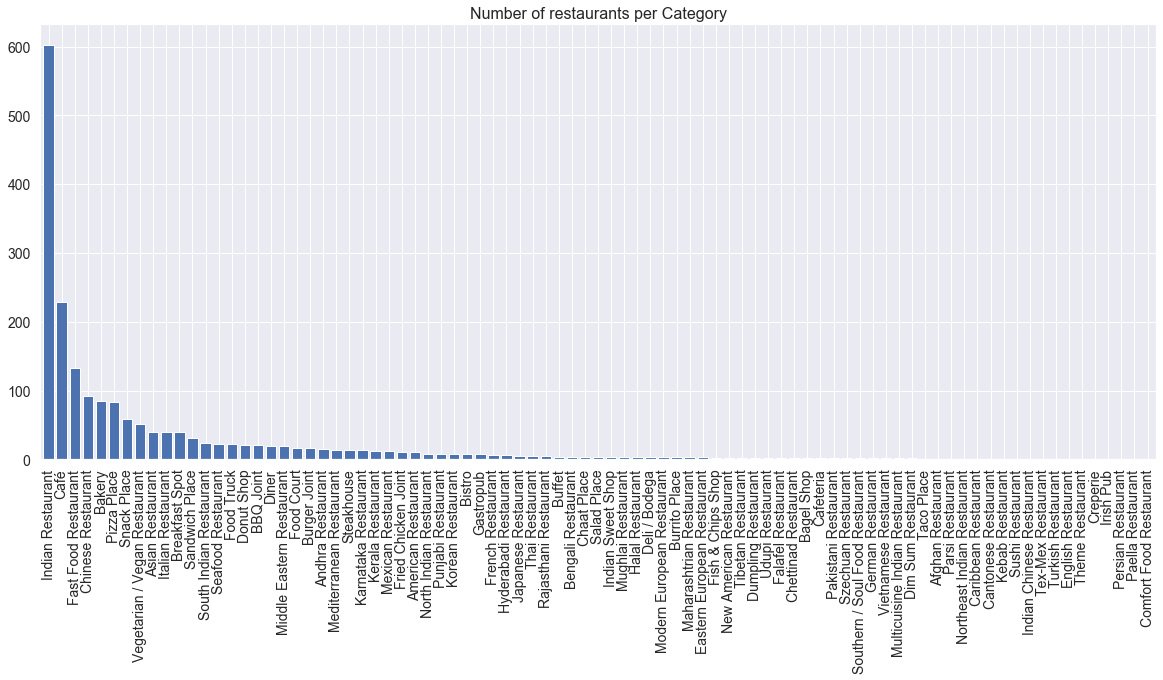

In [188]:
ax=blr_res_cleaning_category['Venue_Category'].value_counts().plot(kind='bar', figsize=(20, 8), rot=90,width=0.8,fontsize=14)
plt.title('Number of restaurants per Category',fontsize=16)

**Indian restaurants** is almost twice as the next Restaurnt type, that is Cafe. While 50% of the type are having just 1 restaurant in Bangalore. So while selecting the neighborhood for **cost and rating**, we will have to consider all restaurants instead of 1 specific restaurant which we want to open.

Now let's plot Restaurants in Different Neighborhoods 

Text(0.5, 1.0, 'Number of restaurants for every neighborhood')

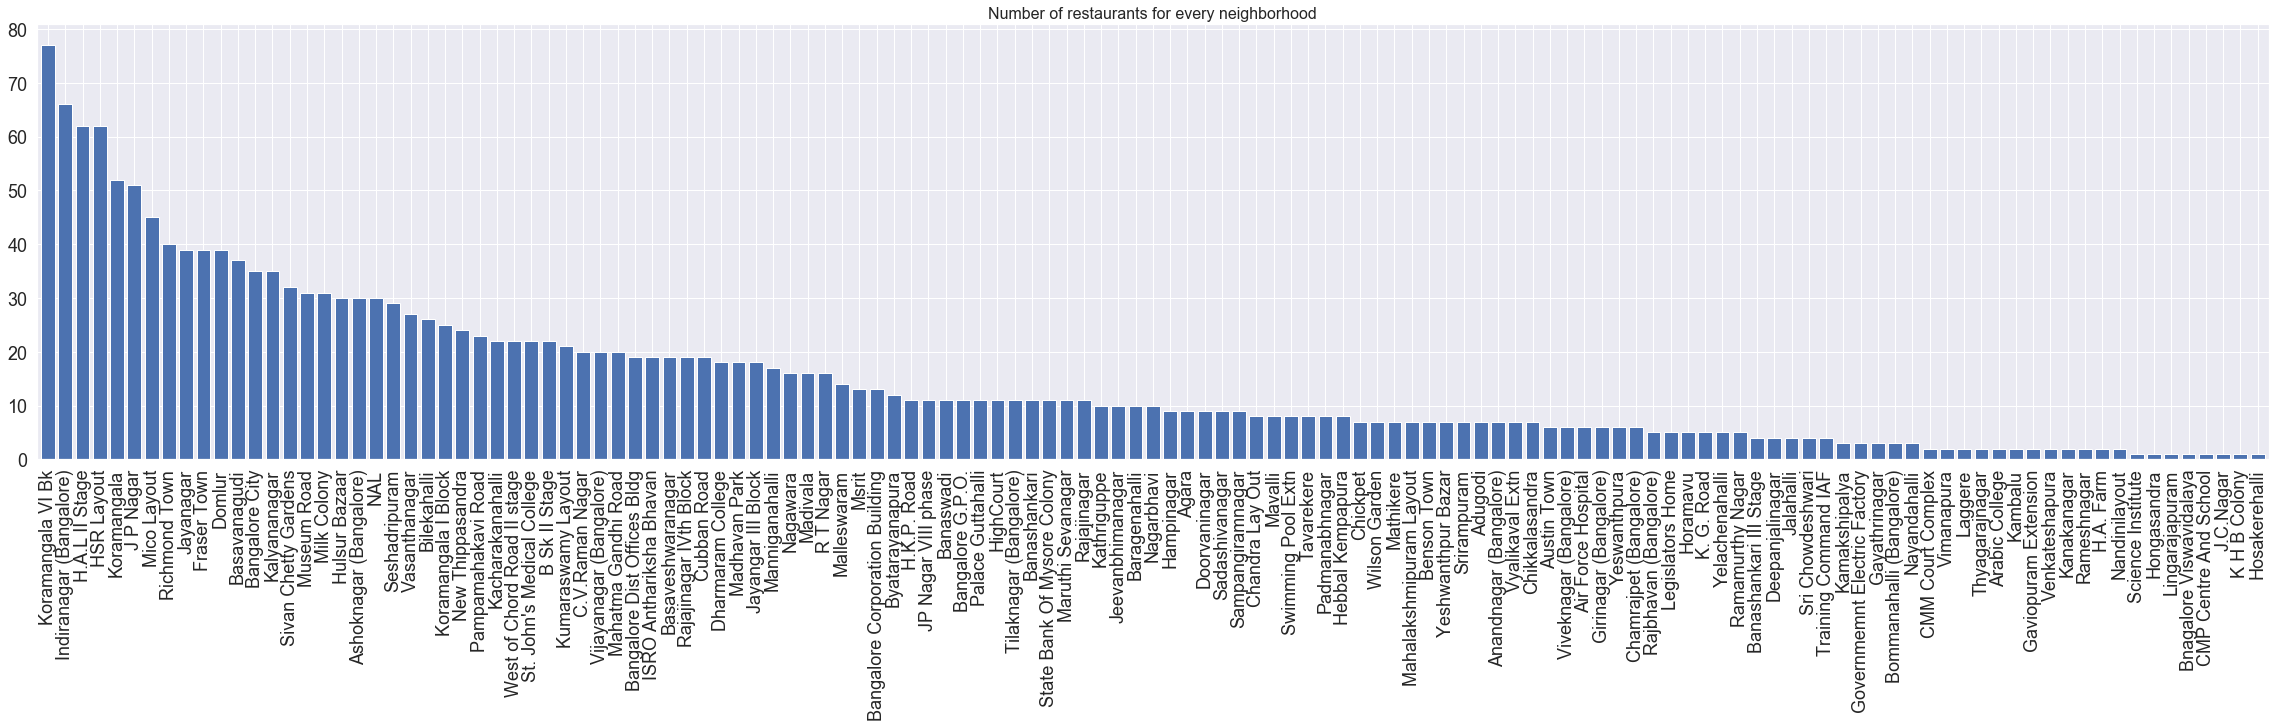

In [189]:
ax=blr_res_cleaning_category['Neighborhood'].value_counts().plot(kind='bar', figsize=(40,8), rot=90,width=0.8,fontsize=18)
plt.title('Number of restaurants for every neighborhood',fontsize=16)

Lets cluster Neighborhoods according to ratings and cost for 2

For this we will neead a dataframe which will have average value of each neighborhood. 

In [190]:
blr_res_neighborhood_mean=blr_res_cleaning_category.groupby(['Neighborhood']).mean()
blr_res_neighborhood_mean['Venue_Rating']=round(blr_res_neighborhood_mean['Venue_Rating'],1)
blr_res_neighborhood_mean.head()

Neighborhood_Distance  Neighborhood_Lat  \
Neighborhood                                                      
Adugodi                                3615.0         12.942004   
Agara                                  7802.0         12.923065   
Air Force Hospital                     3723.0         12.964650   
Anandnagar (Bangalore)                 6658.0         13.031328   
Arabic College                         7149.0         13.030375   

                        Neighborhood_Lng  Venue_Lat  Venue_Lng  Venue_Dist  \
Neighborhood                                                                 
Adugodi                        77.608304  12.934361  77.611254  909.714286   
Agara                          77.646453  12.922894  77.645674  452.222222   
Air Force Hospital             77.628136  12.969905  77.630954  673.000000   
Anandnagar (Bangalore)         77.591313  13.028705  77.592594  665.571429   
Arabic College                 77.621131  13.026082  77.625010  663.500000   

                        Avg_Cost_For_2  Table_Booking  Online_Order  \
Neighborhood                                                          
Adugodi                     457.142857       0.000000      0.857143   
Agara                       583.333333       0.111111      0.888889   
Air Force Hospital          275.000000       0.000000      0.333333   
Anandnagar (Bangalore)      564.285714       0.142857      0.857143   
Arabic College              675.000000       0.000000      1.000000   

                        Venue_Rating  
Neighborhood                          
Adugodi                          4.0  
Agara                            3.7  
Air Force Hospital               3.8  
Anandnagar (Bangalore)           3.8  
Arabic College                   3.9

Lets plot a scatter plot for average rating and cost for 2 and see if there is a relation between them

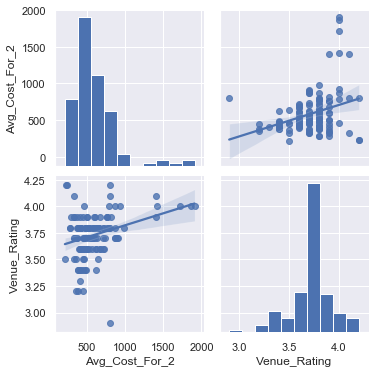

In [191]:
sns.pairplot(blr_res_neighborhood_mean,vars=['Avg_Cost_For_2','Venue_Rating'],kind='reg')

We can see that there exists a relationship betweeen the 2. Now lets check this with neighborhood distance as well

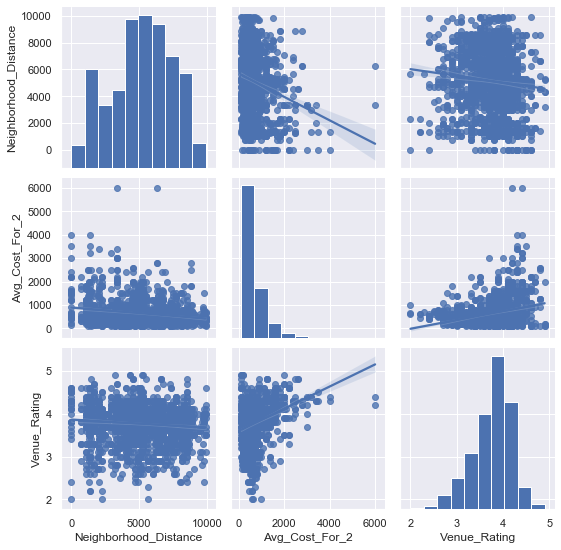

In [192]:
sns.pairplot(blr_res_cleaning_category,vars=['Neighborhood_Distance','Avg_Cost_For_2','Venue_Rating'],kind='reg')

As the distance increases, average rating and average price both decreases but are not effected that much. So all the 3 features can be used for our analysis.


Lets check relationship between count of restaurants and rating and cost for 2. For this we will require another datbase with count ot restaurants in Neighborhoods 

In [195]:
blr_res_neighborhood_counts=blr_res_cleaning_category.groupby(['Neighborhood']).count()
blr_res_neighborhood_count=pd.DataFrame()
blr_res_neighborhood_count['Total Restaurant']=blr_res_neighborhood_counts['Venue_Id']
blr_res_neighborhood_count.head()

Total Restaurant
Neighborhood                            
Adugodi                                7
Agara                                  9
Air Force Hospital                     6
Anandnagar (Bangalore)                 7
Arabic College                         2

merging the 2 datbase (mean and count)

In [200]:
blr_res_merge=blr_res_neighborhood_mean.merge(blr_res_neighborhood_count,left_index=True,right_index=True)
blr_res_merge.head()

Neighborhood_Distance  Neighborhood_Lat  \
Neighborhood                                                      
Adugodi                                3615.0         12.942004   
Agara                                  7802.0         12.923065   
Air Force Hospital                     3723.0         12.964650   
Anandnagar (Bangalore)                 6658.0         13.031328   
Arabic College                         7149.0         13.030375   

                        Neighborhood_Lng  Venue_Lat  Venue_Lng  Venue_Dist  \
Neighborhood                                                                 
Adugodi                        77.608304  12.934361  77.611254  909.714286   
Agara                          77.646453  12.922894  77.645674  452.222222   
Air Force Hospital             77.628136  12.969905  77.630954  673.000000   
Anandnagar (Bangalore)         77.591313  13.028705  77.592594  665.571429   
Arabic College                 77.621131  13.026082  77.625010  663.500000   

                        Avg_Cost_For_2  Table_Booking  Online_Order  \
Neighborhood                                                          
Adugodi                     457.142857       0.000000      0.857143   
Agara                       583.333333       0.111111      0.888889   
Air Force Hospital          275.000000       0.000000      0.333333   
Anandnagar (Bangalore)      564.285714       0.142857      0.857143   
Arabic College              675.000000       0.000000      1.000000   

                        Venue_Rating  Total Restaurant  
Neighborhood                                            
Adugodi                          4.0                 7  
Agara                            3.7                 9  
Air Force Hospital               3.8                 6  
Anandnagar (Bangalore)           3.8                 7  
Arabic College                   3.9                 2

Checking for relationship between number of restaurants nad rating and cost price

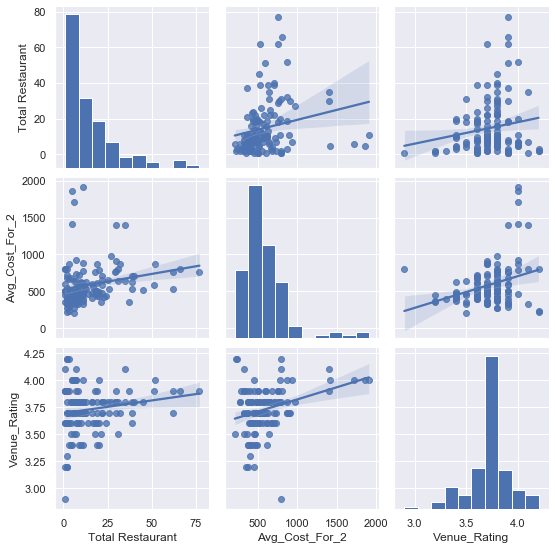

In [201]:
sns.pairplot(blr_res_merge,vars=['Total Restaurant','Avg_Cost_For_2','Venue_Rating'],kind='reg')

Total restuarant also effect rating and average cost. As number  of restaurants increases in a neighborhood, average rating and cost also increases.

##### Now as we know about the dependencies of variables on each other. Lets group the similar Neighborhood depending upon their Average rating and Average Price

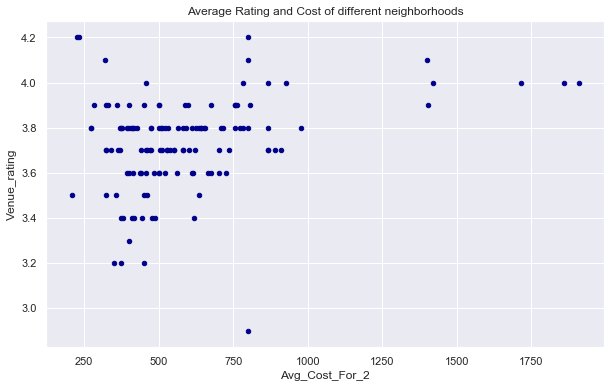

In [207]:
blr_res_neighborhood_mean.plot(kind='scatter',x='Avg_Cost_For_2',y='Venue_Rating',figsize=(10, 6), color='darkblue')

plt.title('Average Rating and Cost of different neighborhoods')
plt.xlabel('Avg_Cost_For_2')
plt.ylabel('Venue_rating')
plt.show()


Lets cluster the neighborhood now according to their Average Cost and Rating

In [209]:
from sklearn.cluster import KMeans

In [211]:
neighborhood=np.array(blr_res_neighborhood_mean[['Venue_Rating','Avg_Cost_For_2']])
neighborhood.shape

(129, 2)

#### K-Means Clustering of Neighborhood

In [213]:


kmeans=KMeans(2)
kmeans.fit(neighborhood)
clusters=pd.DataFrame()
clusters['rating']=neighborhood[:,0]
clusters['Cost']=neighborhood[:,1]
clusters['Cluster_Pred']=kmeans.fit_predict(neighborhood)

clusters.head()

rating        Cost  Cluster_Pred
0     4.0  457.142857             0
1     3.7  583.333333             0
2     3.8  275.000000             0
3     3.8  564.285714             0
4     3.9  675.000000             0

Checkinf for best k value

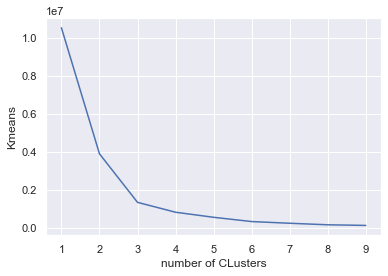

In [214]:
from sklearn import preprocessing
# x_scaled=preprocessing.scale(rating)
WCSS=[]

for i in range(1,10):
    kmeans=KMeans(i)
    kmeans.fit(neighborhood)
    WCSS.append(kmeans.inertia_)
    
plt.plot(range(1,10),WCSS)
plt.xlabel('number of CLusters')
plt.ylabel('Kmeans')
plt.show()

So the best value for k is 4,, now lets cluster the neighborhood again for k=4

In [216]:
kmeans=KMeans(4)
kmeans.fit(neighborhood)
clusters['Cluster_Pred']=kmeans.fit_predict(neighborhood)
clusters.head()

rating        Cost  Cluster_Pred
0     4.0  457.142857             1
1     3.7  583.333333             3
2     3.8  275.000000             1
3     3.8  564.285714             3
4     3.9  675.000000             3

Lest see this on scatter plot

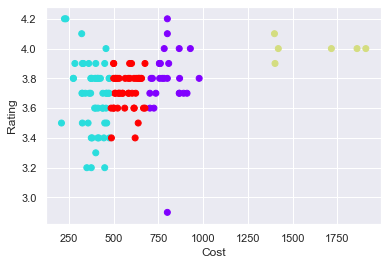

In [217]:
plt.scatter(clusters['Cost'],clusters['rating'],c=clusters['Cluster_Pred'],cmap='rainbow')
plt.xlabel('Cost')
plt.ylabel('Rating')
plt.show()

Lets also plot this on Folium for seeing this with distance as well

In [219]:
# copying cluster number to main dataframe
blr_res_neighborhood_mean['Neighborhood']=blr_res_neighborhood_mean.index
blr_res_neighborhood_mean.reset_index(drop=True,inplace=True)
blr_res_neighborhood_mean['Cluster']=clusters['Cluster_Pred']
blr_res_neighborhood_mean.head()

Neighborhood_Distance  Neighborhood_Lat  Neighborhood_Lng  Venue_Lat  \
0                 3615.0         12.942004         77.608304  12.934361   
1                 7802.0         12.923065         77.646453  12.922894   
2                 3723.0         12.964650         77.628136  12.969905   
3                 6658.0         13.031328         77.591313  13.028705   
4                 7149.0         13.030375         77.621131  13.026082   

   Venue_Lng  Venue_Dist  Avg_Cost_For_2  Table_Booking  Online_Order  \
0  77.611254  909.714286      457.142857       0.000000      0.857143   
1  77.645674  452.222222      583.333333       0.111111      0.888889   
2  77.630954  673.000000      275.000000       0.000000      0.333333   
3  77.592594  665.571429      564.285714       0.142857      0.857143   
4  77.625010  663.500000      675.000000       0.000000      1.000000   

   Venue_Rating  Cluster            Neighborhood  
0           4.0        1                 Adugodi  
1           3.7        3                   Agara  
2           3.8        1      Air Force Hospital  
3           3.8        3  Anandnagar (Bangalore)  
4           3.9        3          Arabic College

#### Folium

In [223]:
blr_map=folium.Map(location=blr_center, zoom_start=12)
# Venue_Id = plugins.MarkerCluster().add_to(blr_map_rating)
for lat, lng, label,cluster,rating in zip(blr_res_neighborhood_mean.Neighborhood_Lat, blr_res_neighborhood_mean.Neighborhood_Lng, blr_res_neighborhood_mean.index,blr_res_neighborhood_mean.Cluster,blr_res_neighborhood_mean.Venue_Rating):
    if cluster==0:
        color_cluster='green'
    elif cluster==1:
        color_cluster='blue'
    elif cluster==2:
        color_cluster='yellow'
    else :
        color_cluster='red'
        radius_cluster=11
    
    folium.CircleMarker(
        location=[lat, lng],
        icon=None,
        popup=label,
        radius=5,
        color=color_cluster
        
    ).add_to(blr_map)

blr_map

As we see from the plot, clusters have been made according to Rating and cost, but it divides the neighborhood based on their distance as well. 

So according to all graphs and observation, and discussion with stakeholders we are dividing the weightage of different components to mark the best neighborhoods.



In [224]:
distance=0.1
average_rating=0.05
average_cost=0.05
total_res=0.15

user_selected_average_rating=0.25
user_selected_average_cost=0.1
user_selected_total_res=0.3


In [227]:
# Final database for our neighborhood selection

blr_res_neighborhood_mean.head()

blr_res_neighborhood=blr_res_neighborhood_mean[['Neighborhood','Neighborhood_Distance','Neighborhood_Lat','Neighborhood_Lng','Avg_Cost_For_2','Venue_Rating']]
blr_res_neighborhood.index=blr_res_neighborhood['Neighborhood']
blr_res_neighborhood.head()

Neighborhood  Neighborhood_Distance  \
Neighborhood                                                            
Adugodi                                Adugodi                 3615.0   
Agara                                    Agara                 7802.0   
Air Force Hospital          Air Force Hospital                 3723.0   
Anandnagar (Bangalore)  Anandnagar (Bangalore)                 6658.0   
Arabic College                  Arabic College                 7149.0   

                        Neighborhood_Lat  Neighborhood_Lng  Avg_Cost_For_2  \
Neighborhood                                                                 
Adugodi                        12.942004         77.608304      457.142857   
Agara                          12.923065         77.646453      583.333333   
Air Force Hospital             12.964650         77.628136      275.000000   
Anandnagar (Bangalore)         13.031328         77.591313      564.285714   
Arabic College                 13.030375         77.621131      675.000000   

                        Venue_Rating  
Neighborhood                          
Adugodi                          4.0  
Agara                            3.7  
Air Force Hospital               3.8  
Anandnagar (Bangalore)           3.8  
Arabic College                   3.9

#### Selection of Restaurant Category by Stakeholder

In [228]:
from tkinter import *

In [270]:
unique_category=pd.DataFrame()
unique_category['Venue_Category']=blr_res_cleaning_category['Venue_Category'].unique()
unique_category.sort_values(by='Venue_Category',inplace=True)
unique_category.reset_index(drop=True,inplace=True)
unique_category_list=unique_category['Venue_Category']

In [329]:
res_selected=0
def var_states():
    global res_selected
    res_selected=var.get()

In [467]:
master = Tk()
Label(master, text="Restaurant Type").grid(row=0,column=2, sticky=W)
Label(master, text="").grid(row=1,column=2, sticky=W)
var = IntVar()
counter=0
row=3
column=0

for i in uninque_category:
    Radiobutton(master, text=unique_category_list[counter], variable=var, value=counter).grid(row=row, column=column, sticky=W)
    counter=counter+1
    if column==4 :
        column=0
        row=row+1
    else:
        column=column+1

        
Label(master, text="").grid(row=row+1,column=2, sticky=W)        
Button(master, text='Predict', command=var_states).grid(row=row+2,column=2, sticky=W, pady=4)

mainloop()

In [346]:
res_selected

41

In [347]:
user_selected_res_type=unique_category['Venue_Category'].iloc[res_selected]
user_selected_res_type

'Indian Restaurant'

#### now we will get details of restaurant , as per stakeholder selected restaurant

In [348]:
blr_user_res_type=blr_res_cleaning_category[blr_res_cleaning_category['Venue_Category']==user_selected_res_type]
blr_user_res_type.head()

Neighborhood  Neighborhood_Distance  Neighborhood_Lat  \
0                     Banaswadi                 7243.0         13.010376   
1                   Koramangala                 5191.0         12.935193   
5           Mahatma Gandhi Road                 1647.0         12.974707   
6   Bangalore Dist Offices Bldg                 1967.0         12.977029   
17                    Jayanagar                 4691.0         12.930774   

    Neighborhood_Lng                      Venue     Venue_Category  \
0          77.648194        Taste of the Nation  Indian Restaurant   
1          77.624481                      Dalma  Indian Restaurant   
5          77.609409         Ullas Refreshments  Indian Restaurant   
6          77.577305           Talk Of The Town  Indian Restaurant   
17         77.583830  Ganesh Darshan Restaurant  Indian Restaurant   

                    Venue_Id  Venue_Lat  Venue_Lng  Venue_Dist  \
0   534d46b2498e81f5e91eddda  13.010413  77.648123         8.0   
1   4c3c263b980320a1f9468ae4  12.935222  77.624375        11.0   
5   4c46a3531ddec92822169b32  12.974605  77.609314        15.0   
6   4f2e6e17e4b007725b6fcc2d  12.976962  77.577152        18.0   
17  4b8115fcf964a5202a9630e3  12.931057  77.583893        32.0   

    Avg_Cost_For_2                                     Venue_Cuisines  \
0            600.0            North Indian, Mughlai, Biryani, Chinese   
1           1600.0  Continental, Mediterranean, North Indian, Chin...   
5            150.0                                       South Indian   
6            900.0                              Chinese, North Indian   
17           150.0                                       South Indian   

    Table_Booking  Online_Order  Venue_Rating Venue_Res_Type  
0             0.0           1.0           3.8  Casual Dining  
1             1.0           1.0           3.9  Casual Dining  
5             0.0           0.0           3.9    Quick Bites  
6             0.0           0.0           3.0            Bar  
17            0.0           0.0           4.1    Quick Bites

In [349]:
#dropping the extra columns

blr_user_res_type.drop(['Venue','Venue_Id','Venue_Lat','Venue_Lng','Venue_Dist','Venue_Cuisines','Table_Booking','Online_Order','Venue_Res_Type'],axis=1,inplace=True)
blr_user_res_type.head()


D:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Neighborhood  Neighborhood_Distance  Neighborhood_Lat  \
0                     Banaswadi                 7243.0         13.010376   
1                   Koramangala                 5191.0         12.935193   
5           Mahatma Gandhi Road                 1647.0         12.974707   
6   Bangalore Dist Offices Bldg                 1967.0         12.977029   
17                    Jayanagar                 4691.0         12.930774   

    Neighborhood_Lng     Venue_Category  Avg_Cost_For_2  Venue_Rating  
0          77.648194  Indian Restaurant           600.0           3.8  
1          77.624481  Indian Restaurant          1600.0           3.9  
5          77.609409  Indian Restaurant           150.0           3.9  
6          77.577305  Indian Restaurant           900.0           3.0  
17         77.583830  Indian Restaurant           150.0           4.1

Getting average rating and average cost in neighborhood of user selected res type

In [350]:
blr_user_res_type_mean=round(blr_user_res_type.groupby(by='Neighborhood').mean(),1)
blr_user_res_type_mean.drop(['Neighborhood_Distance','Neighborhood_Lat','Neighborhood_Lng'],axis=1,inplace=True)
blr_user_res_type_mean.columns=(['User Selected- avg cost','User Selected - Venue Rating'])
blr_user_res_type_mean.head()

User Selected- avg cost  User Selected - Venue Rating
Neighborhood                                                                 
Agara                                     400.0                           3.7
Air Force Hospital                        266.7                           4.0
Anandnagar (Bangalore)                    625.0                           3.8
Arabic College                            675.0                           3.9
Ashoknagar (Bangalore)                   1116.7                           4.1

Getting total count of restaurant of user selected res type

In [351]:
blr_user_res_type_count=blr_user_res_type.groupby(by='Neighborhood').count()
blr_user_res_type_counts=blr_user_res_type_count[['Venue_Rating']]
blr_user_res_type_counts.columns=(['User Selected-Total Restaurants'])

blr_user_res_type_counts.head()

User Selected-Total Restaurants
Neighborhood                                           
Agara                                                 3
Air Force Hospital                                    3
Anandnagar (Bangalore)                                4
Arabic College                                        2
Ashoknagar (Bangalore)                                6

Adding this data in front of average data of all restaurants

In [352]:
blr_user_res_type_final=pd.concat([blr_res_neighborhood,blr_res_neighborhood_count],axis=1, sort=False)
blr_user_res_type_final=pd.concat([blr_user_res_type_final,blr_user_res_type_mean],axis=1, sort=False)
blr_user_res_type_final=pd.concat([blr_user_res_type_final,blr_user_res_type_counts],axis=1, sort=False)
blr_user_res_type_final

Neighborhood  \
Adugodi                                                Adugodi   
Agara                                                    Agara   
Air Force Hospital                          Air Force Hospital   
Anandnagar (Bangalore)                  Anandnagar (Bangalore)   
Arabic College                                  Arabic College   
Ashoknagar (Bangalore)                  Ashoknagar (Bangalore)   
Austin Town                                        Austin Town   
B Sk II Stage                                    B Sk II Stage   
Banashankari                                      Banashankari   
Banashankari III Stage                  Banashankari III Stage   
Banaswadi                                            Banaswadi   
Bangalore City                                  Bangalore City   
Bangalore Corporation Building  Bangalore Corporation Building   
Bangalore Dist Offices Bldg        Bangalore Dist Offices Bldg   
Bangalore G.P.O.                              Bangalore G.P.O.   
Baragenahalli                                    Baragenahalli   
Basavanagudi                                      Basavanagudi   
Basaveshwaranagar                            Basaveshwaranagar   
Benson Town                                        Benson Town   
Bilekahalli                                        Bilekahalli   
Bnagalore Viswavidalaya                Bnagalore Viswavidalaya   
Bommanahalli (Bangalore)              Bommanahalli (Bangalore)   
Byatarayanapura                                Byatarayanapura   
C.V.Raman Nagar                                C.V.Raman Nagar   
CMM Court Complex                            CMM Court Complex   
CMP Centre And School                    CMP Centre And School   
Chamrajpet (Bangalore)                  Chamrajpet (Bangalore)   
Chandra Lay Out                                Chandra Lay Out   
Chickpet                                              Chickpet   
Chikkalasandra                                  Chikkalasandra   
Cubban Road                                        Cubban Road   
Deepanjalinagar                                Deepanjalinagar   
Dharmaram College                            Dharmaram College   
Domlur                                                  Domlur   
Doorvaninagar                                    Doorvaninagar   
Fraser Town                                        Fraser Town   
Gaviopuram Extension                      Gaviopuram Extension   
Gayathrinagar                                    Gayathrinagar   
Girinagar (Bangalore)                    Girinagar (Bangalore)   
Governmemnt Electric Factory      Governmemnt Electric Factory   
H.A. Farm                                            H.A. Farm   
H.A.L II Stage                                  H.A.L II Stage   
H.K.P. Road                                        H.K.P. Road   
HSR Layout                                          HSR Layout   
Hampinagar                                          Hampinagar   
Hebbal Kempapura                              Hebbal Kempapura   
HighCourt                                            HighCourt   
Hongasandra                                        Hongasandra   
Horamavu                                              Horamavu   
Hosakerehalli                                    Hosakerehalli   
Hulsur Bazaar                                    Hulsur Bazaar   
ISRO Anthariksha Bhavan                ISRO Anthariksha Bhavan   
Indiranagar (Bangalore)                Indiranagar (Bangalore)   
J P Nagar                                            J P Nagar   
J.C.Nagar                                            J.C.Nagar   
JP Nagar VIII phase                        JP Nagar VIII phase   
Jalahalli                                            Jalahalli   
Jayanagar                                            Jayanagar   
Jayangar III Block                          Jayangar III Block   
Jeevanbhimanagar                              Jeevanbhimanagar   
K H B Colony            

In [353]:
#replacing na with 0
blr_user_res_type_final=blr_user_res_type_final.fillna(0)
blr_user_res_type_final

Neighborhood  \
Adugodi                                                Adugodi   
Agara                                                    Agara   
Air Force Hospital                          Air Force Hospital   
Anandnagar (Bangalore)                  Anandnagar (Bangalore)   
Arabic College                                  Arabic College   
Ashoknagar (Bangalore)                  Ashoknagar (Bangalore)   
Austin Town                                        Austin Town   
B Sk II Stage                                    B Sk II Stage   
Banashankari                                      Banashankari   
Banashankari III Stage                  Banashankari III Stage   
Banaswadi                                            Banaswadi   
Bangalore City                                  Bangalore City   
Bangalore Corporation Building  Bangalore Corporation Building   
Bangalore Dist Offices Bldg        Bangalore Dist Offices Bldg   
Bangalore G.P.O.                              Bangalore G.P.O.   
Baragenahalli                                    Baragenahalli   
Basavanagudi                                      Basavanagudi   
Basaveshwaranagar                            Basaveshwaranagar   
Benson Town                                        Benson Town   
Bilekahalli                                        Bilekahalli   
Bnagalore Viswavidalaya                Bnagalore Viswavidalaya   
Bommanahalli (Bangalore)              Bommanahalli (Bangalore)   
Byatarayanapura                                Byatarayanapura   
C.V.Raman Nagar                                C.V.Raman Nagar   
CMM Court Complex                            CMM Court Complex   
CMP Centre And School                    CMP Centre And School   
Chamrajpet (Bangalore)                  Chamrajpet (Bangalore)   
Chandra Lay Out                                Chandra Lay Out   
Chickpet                                              Chickpet   
Chikkalasandra                                  Chikkalasandra   
Cubban Road                                        Cubban Road   
Deepanjalinagar                                Deepanjalinagar   
Dharmaram College                            Dharmaram College   
Domlur                                                  Domlur   
Doorvaninagar                                    Doorvaninagar   
Fraser Town                                        Fraser Town   
Gaviopuram Extension                      Gaviopuram Extension   
Gayathrinagar                                    Gayathrinagar   
Girinagar (Bangalore)                    Girinagar (Bangalore)   
Governmemnt Electric Factory      Governmemnt Electric Factory   
H.A. Farm                                            H.A. Farm   
H.A.L II Stage                                  H.A.L II Stage   
H.K.P. Road                                        H.K.P. Road   
HSR Layout                                          HSR Layout   
Hampinagar                                          Hampinagar   
Hebbal Kempapura                              Hebbal Kempapura   
HighCourt                                            HighCourt   
Hongasandra                                        Hongasandra   
Horamavu                                              Horamavu   
Hosakerehalli                                    Hosakerehalli   
Hulsur Bazaar                                    Hulsur Bazaar   
ISRO Anthariksha Bhavan                ISRO Anthariksha Bhavan   
Indiranagar (Bangalore)                Indiranagar (Bangalore)   
J P Nagar                                            J P Nagar   
J.C.Nagar                                            J.C.Nagar   
JP Nagar VIII phase                        JP Nagar VIII phase   
Jalahalli                                            Jalahalli   
Jayanagar                                            Jayanagar   
Jayangar III Block                          Jayangar III Block   
Jeevanbhimanagar                              Jeevanbhimanagar   
K H B Colony            

#### Standardising the Data

In [354]:
max_dist=max(blr_user_res_type_final['Neighborhood_Distance'])
max_cost=max(blr_user_res_type_final['Avg_Cost_For_2'])
max_rating=max(blr_user_res_type_final['Venue_Rating'])
max_rest=max(blr_user_res_type_final['Total Restaurant'])
max_user_cost=max(blr_user_res_type_final['User Selected- avg cost'])
max_user_rating=max(blr_user_res_type_final['User Selected - Venue Rating'])
max_user_rest=max(blr_user_res_type_final['User Selected-Total Restaurants'])

blr_user_res_type_final_standard_scale=pd.DataFrame()
blr_user_res_type_final_standard_scale['Neighborhood Distance']=blr_user_res_type_final['Neighborhood_Distance']/max_dist
blr_user_res_type_final_standard_scale['Avg_Cost_For_2']=blr_user_res_type_final['Avg_Cost_For_2']/max_cost
blr_user_res_type_final_standard_scale['Venue_Rating']=blr_user_res_type_final['Venue_Rating']/max_rating
blr_user_res_type_final_standard_scale['Total Restaurants']=blr_user_res_type_final['Total Restaurant']/max_rest
blr_user_res_type_final_standard_scale['User Selected-avg cost']=blr_user_res_type_final['User Selected- avg cost']/max_user_cost
blr_user_res_type_final_standard_scale['User Selected- venue Rating']=blr_user_res_type_final['User Selected - Venue Rating']/max_user_rating
blr_user_res_type_final_standard_scale['User Selected- Total Restaurants']=blr_user_res_type_final['User Selected-Total Restaurants']/max_user_rest
blr_user_res_type_final_standard_scale['Neighborhood_Lat']=blr_user_res_type_final['Neighborhood_Lat']
blr_user_res_type_final_standard_scale['Neighborhood_Lng']=blr_user_res_type_final['Neighborhood_Lng']

blr_user_res_type_final_standard_scale.head()

Neighborhood Distance  Avg_Cost_For_2  Venue_Rating  \
Adugodi                              0.365152        0.239456      0.952381   
Agara                                0.788081        0.305556      0.880952   
Air Force Hospital                   0.376061        0.144048      0.904762   
Anandnagar (Bangalore)               0.672525        0.295578      0.904762   
Arabic College                       0.722121        0.353571      0.928571   

                        Total Restaurants  User Selected-avg cost  \
Adugodi                          0.090909                0.000000   
Agara                            0.116883                0.179372   
Air Force Hospital               0.077922                0.119596   
Anandnagar (Bangalore)           0.090909                0.280269   
Arabic College                   0.025974                0.302691   

                        User Selected- venue Rating  \
Adugodi                                    0.000000   
Agara                                      0.860465   
Air Force Hospital                         0.930233   
Anandnagar (Bangalore)                     0.883721   
Arabic College                             0.906977   

                        User Selected- Total Restaurants  Neighborhood_Lat  \
Adugodi                                         0.000000         12.942004   
Agara                                           0.096774         12.923065   
Air Force Hospital                              0.096774         12.964650   
Anandnagar (Bangalore)                          0.129032         13.031328   
Arabic College                                  0.064516         13.030375   

                        Neighborhood_Lng  
Adugodi                        77.608304  
Agara                          77.646453  
Air Force Hospital             77.628136  
Anandnagar (Bangalore)         77.591313  
Arabic College                 77.621131

#### Multiplying each column with the weightage decided

In [355]:
blr_user_res_type_final_standard_scale['Weightage']=blr_user_res_type_final_standard_scale['Venue_Rating']*average_rating+blr_user_res_type_final_standard_scale['Avg_Cost_For_2']*average_cost-blr_user_res_type_final_standard_scale['Neighborhood Distance']*distance-blr_user_res_type_final_standard_scale['Total Restaurants']*total_res+blr_user_res_type_final_standard_scale['User Selected- venue Rating']*user_selected_average_rating+blr_user_res_type_final_standard_scale['User Selected-avg cost']*user_selected_average_cost-blr_user_res_type_final_standard_scale['User Selected- Total Restaurants']*user_selected_total_res

blr_user_res_type_final_standard_scale.head() 

Neighborhood Distance  Avg_Cost_For_2  Venue_Rating  \
Adugodi                              0.365152        0.239456      0.952381   
Agara                                0.788081        0.305556      0.880952   
Air Force Hospital                   0.376061        0.144048      0.904762   
Anandnagar (Bangalore)               0.672525        0.295578      0.904762   
Arabic College                       0.722121        0.353571      0.928571   

                        Total Restaurants  User Selected-avg cost  \
Adugodi                          0.090909                0.000000   
Agara                            0.116883                0.179372   
Air Force Hospital               0.077922                0.119596   
Anandnagar (Bangalore)           0.090909                0.280269   
Arabic College                   0.025974                0.302691   

                        User Selected- venue Rating  \
Adugodi                                    0.000000   
Agara                                      0.860465   
Air Force Hospital                         0.930233   
Anandnagar (Bangalore)                     0.883721   
Arabic College                             0.906977   

                        User Selected- Total Restaurants  Neighborhood_Lat  \
Adugodi                                         0.000000         12.942004   
Agara                                           0.096774         12.923065   
Air Force Hospital                              0.096774         12.964650   
Anandnagar (Bangalore)                          0.129032         13.031328   
Arabic College                                  0.064516         13.030375   

                        Neighborhood_Lng  Weightage  
Adugodi                        77.608304   0.009440  
Agara                          77.646453   0.167006  
Air Force Hospital             77.628136   0.218632  
Anandnagar (Bangalore)         77.591313   0.189376  
Arabic College                 77.621131   0.225657

#### sorting the database according to weighatge of neighborhoods

In [356]:
blr_user_res_type_neighborhood=blr_user_res_type_final_standard_scale.sort_values(by='Weightage',ascending=False)
blr_user_res_type_neighborhood.head(10)

Neighborhood Distance  Avg_Cost_For_2  Venue_Rating  \
Legislators Home                     0.137576        0.974286      0.952381   
Palace Guttahalli                    0.342020        1.000000      0.952381   
Yeswanthpura                         0.894848        0.899206      0.952381   
CMM Court Complex                    0.126162        0.419048      1.000000   
Rajbhavan (Bangalore)                0.127273        0.743810      0.952381   
HighCourt                            0.073636        0.466667      0.880952   
Viveknagar (Bangalore)               0.330303        0.218254      0.904762   
K. G. Road                           0.181515        0.267143      0.880952   
Austin Town                          0.275556        0.336111      0.904762   
Chamrajpet (Bangalore)               0.391414        0.178968      0.880952   

                        Total Restaurants  User Selected-avg cost  \
Legislators Home                 0.064935                0.777265   
Palace Guttahalli                0.142857                1.000000   
Yeswanthpura                     0.077922                0.807175   
CMM Court Complex                0.025974                0.089686   
Rajbhavan (Bangalore)            0.064935                0.044843   
HighCourt                        0.142857                0.515695   
Viveknagar (Bangalore)           0.077922                0.257848   
K. G. Road                       0.064935                0.216726   
Austin Town                      0.077922                0.269058   
Chamrajpet (Bangalore)           0.077922                0.067265   

                        User Selected- venue Rating  \
Legislators Home                           0.976744   
Palace Guttahalli                          0.906977   
Yeswanthpura                               0.953488   
CMM Court Complex                          0.976744   
Rajbhavan (Bangalore)                      0.906977   
HighCourt                                  0.790698   
Viveknagar (Bangalore)                     0.976744   
K. G. Road                                 0.906977   
Austin Town                                0.860465   
Chamrajpet (Bangalore)                     0.976744   

                        User Selected- Total Restaurants  Neighborhood_Lat  \
Legislators Home                                0.096774         12.982845   
Palace Guttahalli                               0.161290         12.997414   
Yeswanthpura                                    0.032258         13.025030   
CMM Court Complex                               0.032258         12.973127   
Rajbhavan (Bangalore)                           0.032258         12.982467   
HighCourt                                       0.064516         12.977874   
Viveknagar (Bangalore)                          0.064516         12.954487   
K. G. Road                                      0.096774         12.974276   
Austin Town                                     0.064516         12.958768   
Chamrajpet (Bangalore)                          0.032258         12.956987   

                        Neighborhood_Lng  Weightage  
Legislators Home               77.589609   0.365716  
Palace Guttahalli              77.578042   0.320346  
Yeswanthpura                   77.534024   0.300818  
CMM Court Complex              77.583151   0.297917  
Rajbhavan (Bangalore)          77.591303   0.283893  
HighCourt                      77.592635   0.268478  
Viveknagar (Bangalore)         77.619072   0.262048  
K. G. Road                     77.578219   0.248898  
Austin Town                    77.615995   0.245467  
Chamrajpet (Bangalore)         77.562140   0.243401

In [357]:
blr_user_res_type_neighborhood['Neighborhood']=blr_user_res_type_neighborhood.index
blr_user_res_type_neighborhood.reset_index(drop=True,inplace=True)

##### Converting the data back to actual values, instead of standard values

In [358]:
blr_user_res_type_neighborhood['Neighborhood Distance']=(blr_user_res_type_neighborhood['Neighborhood Distance']*max_dist).astype(int)
blr_user_res_type_neighborhood['Avg_Cost_For_2']=(blr_user_res_type_neighborhood['Avg_Cost_For_2']*max_cost).astype(int)
blr_user_res_type_neighborhood['Venue_Rating']=round((blr_user_res_type_neighborhood['Venue_Rating']*max_rating).astype(float),1)
blr_user_res_type_neighborhood['Total Restaurants']=(blr_user_res_type_neighborhood['Total Restaurants']*max_rest).astype(int)
blr_user_res_type_neighborhood['User Selected-avg cost']=(blr_user_res_type_neighborhood['User Selected-avg cost']*max_user_cost).astype(int)
blr_user_res_type_neighborhood['User Selected- venue Rating']=round((blr_user_res_type_neighborhood['User Selected- venue Rating']*max_user_rating).astype(float),1)
blr_user_res_type_neighborhood['User Selected- Total Restaurants']=(blr_user_res_type_neighborhood['User Selected- Total Restaurants']*max_user_rest).astype(int)

blr_user_res_type_neighborhood.head()

Neighborhood Distance  Avg_Cost_For_2  Venue_Rating  Total Restaurants  \
0                   1362            1860           4.0                  4   
1                   3386            1909           4.0                 11   
2                   8859            1716           4.0                  6   
3                   1249             800           4.2                  2   
4                   1259            1420           4.0                  4   

   User Selected-avg cost  User Selected- venue Rating  \
0                    1733                          4.2   
1                    2230                          3.9   
2                    1800                          4.1   
3                     200                          4.2   
4                     100                          3.9   

   User Selected- Total Restaurants  Neighborhood_Lat  Neighborhood_Lng  \
0                                 3         12.982845         77.589609   
1                                 5         12.997414         77.578042   
2                                 1         13.025030         77.534024   
3                                 1         12.973127         77.583151   
4                                 1         12.982467         77.591303   

   Weightage           Neighborhood  
0   0.365716       Legislators Home  
1   0.320346      Palace Guttahalli  
2   0.300818           Yeswanthpura  
3   0.297917      CMM Court Complex  
4   0.283893  Rajbhavan (Bangalore)

rearranging the columns of dataframe

In [465]:
neighborhood_priority=pd.DataFrame()
neighborhood_priority=blr_user_res_type_neighborhood[['Neighborhood','Neighborhood Distance', 'Avg_Cost_For_2', 'Venue_Rating',
       'Total Restaurants', 'User Selected-avg cost',
       'User Selected- venue Rating', 'User Selected- Total Restaurants',
       'Neighborhood_Lat', 'Neighborhood_Lng', 'Weightage']]

neighborhood_priority.head(10)

Neighborhood  Neighborhood Distance  Avg_Cost_For_2  \
0        Legislators Home                   1362            1860   
1       Palace Guttahalli                   3386            1909   
2            Yeswanthpura                   8859            1716   
3       CMM Court Complex                   1249             800   
4   Rajbhavan (Bangalore)                   1259            1420   
5               HighCourt                    729             890   
6  Viveknagar (Bangalore)                   3270             416   
7              K. G. Road                   1797             510   
8             Austin Town                   2728             641   
9  Chamrajpet (Bangalore)                   3875             341   

   Venue_Rating  Total Restaurants  User Selected-avg cost  \
0           4.0                  4                    1733   
1           4.0                 11                    2230   
2           4.0                  6                    1800   
3           4.2                  2                     200   
4           4.0                  4                     100   
5           3.7                 11                    1150   
6           3.8                  6                     575   
7           3.7                  4                     483   
8           3.8                  6                     600   
9           3.7                  6                     150   

   User Selected- venue Rating  User Selected- Total Restaurants  \
0                          4.2                                 3   
1                          3.9                                 5   
2                          4.1                                 1   
3                          4.2                                 1   
4                          3.9                                 1   
5                          3.4                                 2   
6                          4.2                                 2   
7                          3.9                                 3   
8                          3.7                                 2   
9                          4.2                                 1   

   Neighborhood_Lat  Neighborhood_Lng  Weightage  
0         12.982845         77.589609   0.365716  
1         12.997414         77.578042   0.320346  
2         13.025030         77.534024   0.300818  
3         12.973127         77.583151   0.297917  
4         12.982467         77.591303   0.283893  
5         12.977874         77.592635   0.268478  
6         12.954487         77.619072   0.262048  
7         12.974276         77.578219   0.248898  
8         12.958768         77.615995   0.245467  
9         12.956987         77.562140   0.243401

So the above datframe have neighborhood in order of priorty in which Stakeholder can look for opening a Restaurant of his choice, as he selected at an earlier stage.

Plotting top 10 neighborhoods on bangalore map for user selected Restaurant

In [466]:
user_res=folium.Map(location=blr_center, zoom_start=12)
# Venue_Id = plugins.MarkerCluster().add_to(blr_map_rating)
# folium.Marker(blr_center, popup='Bangalore',color='red',icon=folium.Icon(color='green')).add_to(user_res)
folium.Circle(blr_center, radius=10000, color='blue', fill=False).add_to(user_res)
    

for lat, lng, label,index in zip(neighborhood_priority.Neighborhood_Lat, neighborhood_priority.Neighborhood_Lng, neighborhood_priority.Neighborhood,neighborhood_priority.index):
    if index>=5 and index<10:
        folium.Marker([lat,lng], popup=label,icon=folium.Icon(color='green')).add_to(user_res)
    elif index>=0 and index<5:
        folium.Marker([lat,lng], popup=label,icon=folium.Icon(color='red')).add_to(user_res)

    
    
    
user_res

* Red Markers - Top 5 
* Green Markers - Next 5

For the Third part of the project we will **predict rating (below average/above average) of reaturants** given cuisines and few othre detials are entered by stakeholder

Let's do some preprocessing of data, similar to second part of the project that is cleaning and removing null valures and features not requried.

In [417]:
# Loading the database which we have obtained from several API's in a pandas datframe
blr_res_final=pd.read_pickle('FinaldataforCapstone.pkl')

#### Performing data cleaning and feature selection similar to second step of the project


#Converting Venue Rating to float

blr_res_cleaning_dtype=blr_res_final.copy()

blr_res_cleaning_dtype['Venue_Rating']=round(blr_res_cleaning_dtype['Venue_Rating'].astype(float),1)


blr_res_cleaning_null=blr_res_cleaning_dtype[blr_res_cleaning_dtype['Venue_Rating']!=0]
blr_res_cleaning_null=blr_res_cleaning_null[blr_res_cleaning_null['Venue_Res_Type'].notnull()]
#print(blr_res_cleaning_null.shape)
blr_res_cleaning_null.describe(include='all')

#blr_res_cleaning_null.head()

blr_res=blr_res_cleaning_null.drop(['Venue_Category','Venue_Id'],axis=1)
#blr_res.head()

#blr_res.shape

blr_reg=blr_res.drop(['Neighborhood_Lat','Neighborhood_Lng','Venue_Lat','Venue_Lng'],axis=1)
blr_reg.index=blr_reg['Neighborhood']
# blr_reg.drop('Venue',axis=1,inplace=True)
#blr_reg.head()



blr_reg['Neighborhood'].value_counts()

Koramangala VI Bk                 82
Indiranagar (Bangalore)           68
H.A.L II Stage                    66
HSR Layout                        64
Koramangala                       53
J P Nagar                         53
Mico Layout                       45
Domlur                            41
Richmond Town                     41
Jayanagar                         40
Fraser Town                       39
Basavanagudi                      39
Kalyananagar                      37
Bangalore City                    36
Sivan Chetty Gardens              35
Hulsur Bazaar                     33
NAL                               32
Milk Colony                       31
Museum Road                       31
Ashoknagar (Bangalore)            31
Vasanthanagar                     29
Seshadripuram                     29
Bilekahalli                       26
Koramangala I Block               25
Pampamahakavi Road                25
New Thippasandra                  24
B Sk II Stage                     23
S

We will only consider Neighborhoods which have atleast 5 reaturants

In [418]:
blr_neighborhood=blr_reg[blr_reg['Neighborhood'].value_counts()>5]
print (blr_neighborhood.shape)
blr_neighborhood.describe(include='all')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(1900, 10)


Neighborhood  Neighborhood_Distance            Venue  \
count                1900            1900.000000             1900   
unique                 95                    NaN             1454   
top     Koramangala VI Bk                    NaN  Cafe Coffee Day   
freq                   82                    NaN               57   
mean                  NaN            5126.640526              NaN   
std                   NaN            2299.751650              NaN   
min                   NaN               0.000000              NaN   
25%                   NaN            3557.000000              NaN   
50%                   NaN            5191.000000              NaN   
75%                   NaN            6748.000000              NaN   
max                   NaN            9900.000000              NaN   

         Venue_Dist  Avg_Cost_For_2 Venue_Cuisines  Table_Booking  \
count   1900.000000     1900.000000           1900    1900.000000   
unique          NaN             NaN            702            NaN   
top             NaN             NaN   South Indian            NaN   
freq            NaN             NaN             88            NaN   
mean     554.203684      665.000000            NaN       0.099474   
std      250.299715      546.665174            NaN       0.299376   
min        8.000000      100.000000            NaN       0.000000   
25%      362.000000      300.000000            NaN       0.000000   
50%      552.500000      500.000000            NaN       0.000000   
75%      760.000000      800.000000            NaN       0.000000   
max     1001.000000     6000.000000            NaN       1.000000   

        Online_Order  Venue_Rating Venue_Res_Type  
count    1900.000000   1900.000000           1900  
unique           NaN           NaN             16  
top              NaN           NaN    Quick Bites  
freq             NaN           NaN            705  
mean        0.650000      3.770632            NaN  
std         0.477095      0.448073            NaN  
min         0.000000      2.000000            NaN  
25%         0.000000      3.500000            NaN  
50%         1.000000      3.800000            NaN  
75%         1.000000      4.100000            NaN  
max         1.000000      4.900000            NaN

#### In this part of project our main focus will be on Venue res_type and Cuisines, extracted from Zomato API. So let's check for **Venue res_type** first

In [419]:
blr_neighborhood['Venue_Res_Type'].value_counts()

Quick Bites        705
Casual Dining      665
Café               213
Bakery              61
Dessert Parlour     50
Sweet Shop          41
Beverage Shop       33
Fine Dining         31
Bar                 27
Food Court          25
Lounge              13
Microbrewery        10
Pub                  9
Mess                 8
Kiosk                7
Paan Shop            2
Name: Venue_Res_Type, dtype: int64

In [420]:
# Removing Paan Shop from the dataframe
blr_venue_type=blr_neighborhood[blr_neighborhood['Venue_Res_Type']!='Paan Shop']
# blr_venue_type.index=blr_venue_type['Venue_Res_Type']
blr_venue_type.reset_index(drop=True,inplace=True)
blr_venue_type.head()

Neighborhood  Neighborhood_Distance                Venue  \
0                Banaswadi                 7243.0  Taste of the Nation   
1              Koramangala                 5191.0                Dalma   
2              Fraser Town                 3557.0        Albert Bakery   
3  Indiranagar (Bangalore)                 5075.0            Pizza Hut   
4              Malleswaram                 4668.0         Veena Stores   

   Venue_Dist  Avg_Cost_For_2  \
0         8.0           600.0   
1        11.0          1600.0   
2        12.0           200.0   
3        12.0           600.0   
4        14.0           300.0   

                                      Venue_Cuisines  Table_Booking  \
0            North Indian, Mughlai, Biryani, Chinese            0.0   
1  Continental, Mediterranean, North Indian, Chin...            1.0   
2                       Bakery, Fast Food, Beverages            0.0   
3            Pizza, Fast Food, Finger Food, American            0.0   
4                                          Fast Food            0.0   

   Online_Order  Venue_Rating   Venue_Res_Type  
0           1.0           3.8    Casual Dining  
1           1.0           3.9    Casual Dining  
2           0.0           3.0  Dessert Parlour  
3           1.0           3.3    Casual Dining  
4           1.0           3.3      Quick Bites

We will merge same res type into 1, and **try to minimise count of res_type** for better prediction

In [421]:
counter=0
for rows in blr_venue_type.iterrows():
    if blr_venue_type['Venue_Res_Type'].loc[counter]=='Bakery' or blr_venue_type['Venue_Res_Type'].loc[counter]=='Beverage Shop':
        blr_venue_type['Venue_Res_Type'].loc[counter]='Café'
    elif blr_venue_type['Venue_Res_Type'].loc[counter]=='Sweet Shop':
        blr_venue_type['Venue_Res_Type'].loc[counter]='Dessert Parlour'
    elif blr_venue_type['Venue_Res_Type'].loc[counter]=='Food Court' or blr_venue_type['Venue_Res_Type'].loc[counter]=='Mess' or blr_venue_type['Venue_Res_Type'].loc[counter]=='Kiosk':
        blr_venue_type['Venue_Res_Type'].loc[counter]='Quick Bites'
    elif blr_venue_type['Venue_Res_Type'].loc[counter]=='Bar' or blr_venue_type['Venue_Res_Type'].loc[counter]=='Microbrewery' or blr_venue_type['Venue_Res_Type'].loc[counter]=='Pub':
        blr_venue_type['Venue_Res_Type'].loc[counter]='Pubs'
    counter=counter+1
        
blr_venue_type['Venue_Res_Type'].value_counts()

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.p

Quick Bites        745
Casual Dining      665
Café               307
Dessert Parlour     91
Pubs                46
Fine Dining         31
Lounge              13
Name: Venue_Res_Type, dtype: int64

In [422]:
counter=0
for rows in blr_venue_type.iterrows():
    if blr_venue_type['Venue_Res_Type'].loc[counter]=='Fine Dining' or blr_venue_type['Venue_Res_Type'].loc[counter]=='Casual Dining' or blr_venue_type['Venue_Res_Type'].loc[counter]=='Lounge':
        blr_venue_type['Venue_Res_Type'].loc[counter]='Dining'
    elif blr_venue_type['Venue_Res_Type'].loc[counter]=='Café' or blr_venue_type['Venue_Res_Type'].loc[counter]=='Dessert Parlour':
        blr_venue_type['Venue_Res_Type'].loc[counter]='Cafe and Dessert Parlour'
    counter=counter+1
        
blr_venue_type['Venue_Res_Type'].value_counts()

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Quick Bites                 745
Dining                      709
Cafe and Dessert Parlour    398
Pubs                         46
Name: Venue_Res_Type, dtype: int64

In [423]:
blr_venue_type=blr_venue_type[blr_venue_type['Venue_Res_Type']!='Pubs']
blr_venue_type['Venue_Res_Type'].value_counts()
print(blr_venue_type['Venue_Res_Type'].value_counts())
blr_venue_type.head()

Quick Bites                 745
Dining                      709
Cafe and Dessert Parlour    398
Name: Venue_Res_Type, dtype: int64


Neighborhood  Neighborhood_Distance                Venue  \
0                Banaswadi                 7243.0  Taste of the Nation   
1              Koramangala                 5191.0                Dalma   
2              Fraser Town                 3557.0        Albert Bakery   
3  Indiranagar (Bangalore)                 5075.0            Pizza Hut   
4              Malleswaram                 4668.0         Veena Stores   

   Venue_Dist  Avg_Cost_For_2  \
0         8.0           600.0   
1        11.0          1600.0   
2        12.0           200.0   
3        12.0           600.0   
4        14.0           300.0   

                                      Venue_Cuisines  Table_Booking  \
0            North Indian, Mughlai, Biryani, Chinese            0.0   
1  Continental, Mediterranean, North Indian, Chin...            1.0   
2                       Bakery, Fast Food, Beverages            0.0   
3            Pizza, Fast Food, Finger Food, American            0.0   
4                                          Fast Food            0.0   

   Online_Order  Venue_Rating            Venue_Res_Type  
0           1.0           3.8                    Dining  
1           1.0           3.9                    Dining  
2           0.0           3.0  Cafe and Dessert Parlour  
3           1.0           3.3                    Dining  
4           1.0           3.3               Quick Bites

So we have converted res)type from 19 to 3 different features. Now we will look for **Venue_Cuisines**

In [424]:
blr_venue_type['Venue_Cuisines'].value_counts()

South Indian                                                                          88
North Indian, Chinese                                                                 57
South Indian, North Indian, Chinese                                                   49
Cafe, Fast Food, Desserts, Beverages, Sandwich                                        44
North Indian                                                                          38
Pizza, Fast Food                                                                      27
Fast Food                                                                             25
Pizza, Fast Food, Finger Food, American                                               24
Burger, Fast Food, Finger Food, Beverages                                             23
Bakery                                                                                23
Healthy Food, Salad, Sandwich, Wraps, Rolls, Beverages                                22
Mithai, Street Food  

We will convert cuisines to features. But for that let's split the data to list in cuisines column

In [425]:
blr_cuisines=blr_venue_type.copy()
blr_cuisines.replace({', ':','},regex=True,inplace=True)
blr_cuisines['Venue_Cuisines']=blr_cuisines.Venue_Cuisines.str.split(',')
blr_cuisines.head()

Neighborhood  Neighborhood_Distance                Venue  \
0                Banaswadi                 7243.0  Taste of the Nation   
1              Koramangala                 5191.0                Dalma   
2              Fraser Town                 3557.0        Albert Bakery   
3  Indiranagar (Bangalore)                 5075.0            Pizza Hut   
4              Malleswaram                 4668.0         Veena Stores   

   Venue_Dist  Avg_Cost_For_2  \
0         8.0           600.0   
1        11.0          1600.0   
2        12.0           200.0   
3        12.0           600.0   
4        14.0           300.0   

                                      Venue_Cuisines  Table_Booking  \
0          [North Indian, Mughlai, Biryani, Chinese]            0.0   
1  [Continental, Mediterranean, North Indian, Chi...            1.0   
2                     [Bakery, Fast Food, Beverages]            0.0   
3          [Pizza, Fast Food, Finger Food, American]            0.0   
4                                        [Fast Food]            0.0   

   Online_Order  Venue_Rating            Venue_Res_Type  
0           1.0           3.8                    Dining  
1           1.0           3.9                    Dining  
2           0.0           3.0  Cafe and Dessert Parlour  
3           1.0           3.3                    Dining  
4           1.0           3.3               Quick Bites

In [426]:
blr_only_cuisines=blr_cuisines[['Venue_Cuisines']]
blr_only_cuisines.head()

Venue_Cuisines
0          [North Indian, Mughlai, Biryani, Chinese]
1  [Continental, Mediterranean, North Indian, Chi...
2                     [Bakery, Fast Food, Beverages]
3          [Pizza, Fast Food, Finger Food, American]
4                                        [Fast Food]

In [427]:
## Checking for unique cuisines
counter1=0
unique_list=[]
for i,row in blr_only_cuisines.iterrows():
    lists=row['Venue_Cuisines']
    for x in lists:
        if x not in unique_list: 
            unique_list.append(x) 
            


In [428]:
blr_cuisines_unique=pd.DataFrame(unique_list,columns=['Cuisines'])
blr_cuisines_unique.head()

Cuisines
0  North Indian
1       Mughlai
2       Biryani
3       Chinese
4   Continental

In [429]:
blr_cuisines_unique.count()

Cuisines    83
dtype: int64

In [430]:
blr_cuisines_unique.sort_values(by='Cuisines')

Cuisines
37          Afghan
79         African
11        American
17          Andhra
39         Arabian
29           Asian
82        Assamese
73          Awadhi
43             BBQ
7           Bakery
45        Bar Food
33         Bengali
9        Beverages
2          Biryani
14          Burger
23            Cafe
76       Cantonese
46       Chettinad
3          Chinese
55          Coffee
4      Continental
13        Desserts
49        European
8        Fast Food
6      Finger Food
60          French
65          German
74            Goan
70           Greek
69        Gujarati
18    Healthy Food
42      Hyderabadi
32       Ice Cream
72      Indonesian
24         Italian
52        Japanese
41          Juices
62        Kashmiri
22           Kebab
25          Kerala
53          Konkan
66          Korean
51        Lebanese
75        Lucknowi
28   Maharashtrian
80       Malaysian
44     Mangalorean
5    Mediterranean
47         Mexican
27  Middle Eastern
34          Mithai
57   Modern Indian
31           Momos
1          Mughlai
59            Naga
56        Nepalese
58   North Eastern
0     North Indian
78            Odia
68            Paan
63           Parsi
77        Peruvian
10           Pizza
71      Portuguese
50      Rajasthani
21           Rolls
19           Salad
15        Sandwich
30         Seafood
81     Singaporean
12    South Indian
67         Spanish
26           Steak
16     Street Food
64           Sushi
61           Tamil
40             Tea
48         Tex-Mex
35            Thai
54         Tibetan
38         Turkish
36      Vietnamese
20           Wraps

Converting Cuisines to features - **One hot Encoding**

In [431]:
blr_cuisines_onehot=blr_cuisines.copy()

for index, row in blr_cuisines_onehot.iterrows():
    for cuisines in row['Venue_Cuisines']:
        blr_cuisines_onehot.at[index, cuisines] = 1
        
        
blr_cuisines_onehot.head()

Neighborhood  Neighborhood_Distance                Venue  \
0                Banaswadi                 7243.0  Taste of the Nation   
1              Koramangala                 5191.0                Dalma   
2              Fraser Town                 3557.0        Albert Bakery   
3  Indiranagar (Bangalore)                 5075.0            Pizza Hut   
4              Malleswaram                 4668.0         Veena Stores   

   Venue_Dist  Avg_Cost_For_2  \
0         8.0           600.0   
1        11.0          1600.0   
2        12.0           200.0   
3        12.0           600.0   
4        14.0           300.0   

                                      Venue_Cuisines  Table_Booking  \
0          [North Indian, Mughlai, Biryani, Chinese]            0.0   
1  [Continental, Mediterranean, North Indian, Chi...            1.0   
2                     [Bakery, Fast Food, Beverages]            0.0   
3          [Pizza, Fast Food, Finger Food, American]            0.0   
4                                        [Fast Food]            0.0   

   Online_Order  Venue_Rating            Venue_Res_Type  North Indian  \
0           1.0           3.8                    Dining           1.0   
1           1.0           3.9                    Dining           1.0   
2           0.0           3.0  Cafe and Dessert Parlour           NaN   
3           1.0           3.3                    Dining           NaN   
4           1.0           3.3               Quick Bites           NaN   

   Mughlai  Biryani  Chinese  Continental  Mediterranean  Finger Food  Bakery  \
0      1.0      1.0      1.0          NaN            NaN          NaN     NaN   
1      NaN      NaN      1.0          1.0            1.0          1.0     NaN   
2      NaN      NaN      NaN          NaN            NaN          NaN     1.0   
3      NaN      NaN      NaN          NaN            NaN          1.0     NaN   
4      NaN      NaN      NaN          NaN            NaN          NaN     NaN   

   Fast Food  Beverages  Pizza  American  South Indian  Desserts  Burger  \
0        NaN        NaN    NaN       NaN           NaN       NaN     NaN   
1        NaN        NaN    NaN       NaN           NaN       NaN     NaN   
2        1.0        1.0    NaN       NaN           NaN       NaN     NaN   
3        1.0        NaN    1.0       1.0           NaN       NaN     NaN   
4        1.0        NaN    NaN       NaN           NaN       NaN     NaN   

   Sandwich  Street Food  Andhra  Healthy Food  Salad  Wraps  Rolls  Kebab  \
0       NaN          NaN     NaN           NaN    NaN    NaN    NaN    NaN   
1       NaN          NaN     NaN           NaN    NaN    NaN    NaN    NaN   
2       NaN          NaN     NaN           NaN    NaN    NaN    NaN    NaN   
3       NaN          NaN     NaN           NaN    NaN    NaN    NaN    NaN   
4       NaN          NaN     NaN           NaN    NaN    NaN    NaN    NaN   

   Cafe  Italian  Kerala  Steak  Middle Eastern  Maharashtrian  Asian  \
0   NaN      NaN     NaN    NaN             NaN            NaN    NaN   
1   NaN      NaN     NaN    NaN             NaN            NaN    NaN   
2   NaN      NaN     NaN    NaN             NaN            NaN    NaN   
3   NaN      NaN     NaN    NaN             NaN            NaN    NaN   
4   NaN      NaN     NaN    NaN             NaN            NaN    NaN   

   Seafood  Momos  Ice Cream  Bengali  Mithai  Thai  Vietnamese  Afghan  \
0      NaN    NaN        NaN      NaN     NaN   NaN         NaN     NaN   
1      NaN    NaN        NaN      NaN     NaN   NaN         NaN     NaN   
2      NaN    NaN        NaN      NaN     NaN   NaN         NaN     NaN   
3      NaN    NaN        NaN      NaN     NaN   NaN         NaN     NaN   
4      NaN    NaN        NaN      NaN     NaN   NaN         NaN     NaN   

   Turkish  Arabian  Tea  Juices  Hyderabadi  BBQ  Mangalorean  Bar Food  \
0      NaN      NaN  NaN     NaN         NaN  NaN          NaN       NaN   
1      NaN      NaN  NaN     NaN         NaN  NaN

**One Hot Encoding** for res_type

In [432]:
blr_res_type_onehot=blr_cuisines_onehot.drop('Venue_Cuisines',axis=1)
counter=0
for i,row in blr_res_type_onehot.iterrows():
    blr_res_type_onehot[row['Venue_Res_Type']]=0
    
for i,row in blr_res_type_onehot.iterrows():
    blr_res_type_onehot[row['Venue_Res_Type']].loc[i]=1

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [433]:
blr_res_type_onehot.drop('Venue_Res_Type',axis=1,inplace=True)
blr_res_type_onehot.head()

Neighborhood  Neighborhood_Distance                Venue  \
0                Banaswadi                 7243.0  Taste of the Nation   
1              Koramangala                 5191.0                Dalma   
2              Fraser Town                 3557.0        Albert Bakery   
3  Indiranagar (Bangalore)                 5075.0            Pizza Hut   
4              Malleswaram                 4668.0         Veena Stores   

   Venue_Dist  Avg_Cost_For_2  Table_Booking  Online_Order  Venue_Rating  \
0         8.0           600.0            0.0           1.0           3.8   
1        11.0          1600.0            1.0           1.0           3.9   
2        12.0           200.0            0.0           0.0           3.0   
3        12.0           600.0            0.0           1.0           3.3   
4        14.0           300.0            0.0           1.0           3.3   

   North Indian  Mughlai  Biryani  Chinese  Continental  Mediterranean  \
0           1.0      1.0      1.0      1.0          NaN            NaN   
1           1.0      NaN      NaN      1.0          1.0            1.0   
2           NaN      NaN      NaN      NaN          NaN            NaN   
3           NaN      NaN      NaN      NaN          NaN            NaN   
4           NaN      NaN      NaN      NaN          NaN            NaN   

   Finger Food  Bakery  Fast Food  Beverages  Pizza  American  South Indian  \
0          NaN     NaN        NaN        NaN    NaN       NaN           NaN   
1          1.0     NaN        NaN        NaN    NaN       NaN           NaN   
2          NaN     1.0        1.0        1.0    NaN       NaN           NaN   
3          1.0     NaN        1.0        NaN    1.0       1.0           NaN   
4          NaN     NaN        1.0        NaN    NaN       NaN           NaN   

   Desserts  Burger  Sandwich  Street Food  Andhra  Healthy Food  Salad  \
0       NaN     NaN       NaN          NaN     NaN           NaN    NaN   
1       NaN     NaN       NaN          NaN     NaN           NaN    NaN   
2       NaN     NaN       NaN          NaN     NaN           NaN    NaN   
3       NaN     NaN       NaN          NaN     NaN           NaN    NaN   
4       NaN     NaN       NaN          NaN     NaN           NaN    NaN   

   Wraps  Rolls  Kebab  Cafe  Italian  Kerala  Steak  Middle Eastern  \
0    NaN    NaN    NaN   NaN      NaN     NaN    NaN             NaN   
1    NaN    NaN    NaN   NaN      NaN     NaN    NaN             NaN   
2    NaN    NaN    NaN   NaN      NaN     NaN    NaN             NaN   
3    NaN    NaN    NaN   NaN      NaN     NaN    NaN             NaN   
4    NaN    NaN    NaN   NaN      NaN     NaN    NaN             NaN   

   Maharashtrian  Asian  Seafood  Momos  Ice Cream  Bengali  Mithai  Thai  \
0            NaN    NaN      NaN    NaN        NaN      NaN     NaN   NaN   
1            NaN    NaN      NaN    NaN        NaN      NaN     NaN   NaN   
2            NaN    NaN      NaN    NaN        NaN      NaN     NaN   NaN   
3            NaN    NaN      NaN    NaN        NaN      NaN     NaN   NaN   
4            NaN    NaN      NaN    NaN        NaN      NaN     NaN   NaN   

   Vietnamese  Afghan  Turkish  Arabian  Tea  Juices  Hyderabadi  BBQ  \
0         NaN     NaN      NaN      NaN  NaN     NaN         NaN  NaN   
1         NaN     NaN      NaN      NaN  NaN     NaN         NaN  NaN   
2         NaN     NaN      NaN      NaN  NaN     NaN         NaN  NaN   
3         NaN     NaN      NaN      NaN  NaN     NaN         NaN  NaN   
4         NaN     NaN      NaN      NaN  NaN     NaN         NaN  NaN   

   Mangalorean  Bar Food  Chettinad  Mexican  Tex-Mex  European  Rajasthani  \
0          NaN       NaN        NaN      NaN      NaN       NaN         NaN   
1          NaN       NaN        NaN      NaN      NaN       NaN         NaN   
2          NaN       NaN        NaN      NaN      NaN       NaN         NaN   
3          NaN       NaN        NaN      NaN      NaN       NaN         NaN   
4          

In [434]:
# Converting NAN to 0

blr_res_df=blr_res_type_onehot.fillna(0)
blr_res_df.head()

Neighborhood  Neighborhood_Distance                Venue  \
0                Banaswadi                 7243.0  Taste of the Nation   
1              Koramangala                 5191.0                Dalma   
2              Fraser Town                 3557.0        Albert Bakery   
3  Indiranagar (Bangalore)                 5075.0            Pizza Hut   
4              Malleswaram                 4668.0         Veena Stores   

   Venue_Dist  Avg_Cost_For_2  Table_Booking  Online_Order  Venue_Rating  \
0         8.0           600.0            0.0           1.0           3.8   
1        11.0          1600.0            1.0           1.0           3.9   
2        12.0           200.0            0.0           0.0           3.0   
3        12.0           600.0            0.0           1.0           3.3   
4        14.0           300.0            0.0           1.0           3.3   

   North Indian  Mughlai  Biryani  Chinese  Continental  Mediterranean  \
0           1.0      1.0      1.0      1.0          0.0            0.0   
1           1.0      0.0      0.0      1.0          1.0            1.0   
2           0.0      0.0      0.0      0.0          0.0            0.0   
3           0.0      0.0      0.0      0.0          0.0            0.0   
4           0.0      0.0      0.0      0.0          0.0            0.0   

   Finger Food  Bakery  Fast Food  Beverages  Pizza  American  South Indian  \
0          0.0     0.0        0.0        0.0    0.0       0.0           0.0   
1          1.0     0.0        0.0        0.0    0.0       0.0           0.0   
2          0.0     1.0        1.0        1.0    0.0       0.0           0.0   
3          1.0     0.0        1.0        0.0    1.0       1.0           0.0   
4          0.0     0.0        1.0        0.0    0.0       0.0           0.0   

   Desserts  Burger  Sandwich  Street Food  Andhra  Healthy Food  Salad  \
0       0.0     0.0       0.0          0.0     0.0           0.0    0.0   
1       0.0     0.0       0.0          0.0     0.0           0.0    0.0   
2       0.0     0.0       0.0          0.0     0.0           0.0    0.0   
3       0.0     0.0       0.0          0.0     0.0           0.0    0.0   
4       0.0     0.0       0.0          0.0     0.0           0.0    0.0   

   Wraps  Rolls  Kebab  Cafe  Italian  Kerala  Steak  Middle Eastern  \
0    0.0    0.0    0.0   0.0      0.0     0.0    0.0             0.0   
1    0.0    0.0    0.0   0.0      0.0     0.0    0.0             0.0   
2    0.0    0.0    0.0   0.0      0.0     0.0    0.0             0.0   
3    0.0    0.0    0.0   0.0      0.0     0.0    0.0             0.0   
4    0.0    0.0    0.0   0.0      0.0     0.0    0.0             0.0   

   Maharashtrian  Asian  Seafood  Momos  Ice Cream  Bengali  Mithai  Thai  \
0            0.0    0.0      0.0    0.0        0.0      0.0     0.0   0.0   
1            0.0    0.0      0.0    0.0        0.0      0.0     0.0   0.0   
2            0.0    0.0      0.0    0.0        0.0      0.0     0.0   0.0   
3            0.0    0.0      0.0    0.0        0.0      0.0     0.0   0.0   
4            0.0    0.0      0.0    0.0        0.0      0.0     0.0   0.0   

   Vietnamese  Afghan  Turkish  Arabian  Tea  Juices  Hyderabadi  BBQ  \
0         0.0     0.0      0.0      0.0  0.0     0.0         0.0  0.0   
1         0.0     0.0      0.0      0.0  0.0     0.0         0.0  0.0   
2         0.0     0.0      0.0      0.0  0.0     0.0         0.0  0.0   
3         0.0     0.0      0.0      0.0  0.0     0.0         0.0  0.0   
4         0.0     0.0      0.0      0.0  0.0     0.0         0.0  0.0   

   Mangalorean  Bar Food  Chettinad  Mexican  Tex-Mex  European  Rajasthani  \
0          0.0       0.0        0.0      0.0      0.0       0.0         0.0   
1          0.0       0.0        0.0      0.0      0.0       0.0         0.0   
2          0.0       0.0        0.0      0.0      0.0       0.0         0.0   
3          0.0       0.0        0.0      0.0      0.0       0.0         0.0   
4          

In [435]:
blr_res_df.shape

(1852, 94)

so finally we have 1852 restaurant for our model

In [436]:

blr_res_df.index=blr_res_df['Venue']
blr_res_df.drop(['Neighborhood','Venue'],axis=1,inplace=True)
blr_res_df.head()

Neighborhood_Distance  Venue_Dist  Avg_Cost_For_2  \
Venue                                                                    
Taste of the Nation                 7243.0         8.0           600.0   
Dalma                               5191.0        11.0          1600.0   
Albert Bakery                       3557.0        12.0           200.0   
Pizza Hut                           5075.0        12.0           600.0   
Veena Stores                        4668.0        14.0           300.0   

                     Table_Booking  Online_Order  Venue_Rating  North Indian  \
Venue                                                                          
Taste of the Nation            0.0           1.0           3.8           1.0   
Dalma                          1.0           1.0           3.9           1.0   
Albert Bakery                  0.0           0.0           3.0           0.0   
Pizza Hut                      0.0           1.0           3.3           0.0   
Veena Stores                   0.0           1.0           3.3           0.0   

                     Mughlai  Biryani  Chinese  Continental  Mediterranean  \
Venue                                                                        
Taste of the Nation      1.0      1.0      1.0          0.0            0.0   
Dalma                    0.0      0.0      1.0          1.0            1.0   
Albert Bakery            0.0      0.0      0.0          0.0            0.0   
Pizza Hut                0.0      0.0      0.0          0.0            0.0   
Veena Stores             0.0      0.0      0.0          0.0            0.0   

                     Finger Food  Bakery  Fast Food  Beverages  Pizza  \
Venue                                                                   
Taste of the Nation          0.0     0.0        0.0        0.0    0.0   
Dalma                        1.0     0.0        0.0        0.0    0.0   
Albert Bakery                0.0     1.0        1.0        1.0    0.0   
Pizza Hut                    1.0     0.0        1.0        0.0    1.0   
Veena Stores                 0.0     0.0        1.0        0.0    0.0   

                     American  South Indian  Desserts  Burger  Sandwich  \
Venue                                                                     
Taste of the Nation       0.0           0.0       0.0     0.0       0.0   
Dalma                     0.0           0.0       0.0     0.0       0.0   
Albert Bakery             0.0           0.0       0.0     0.0       0.0   
Pizza Hut                 1.0           0.0       0.0     0.0       0.0   
Veena Stores              0.0           0.0       0.0     0.0       0.0   

                     Street Food  Andhra  Healthy Food  Salad  Wraps  Rolls  \
Venue                                                                         
Taste of the Nation          0.0     0.0           0.0    0.0    0.0    0.0   
Dalma                        0.0     0.0           0.0    0.0    0.0    0.0   
Albert Bakery                0.0     0.0           0.0    0.0    0.0    0.0   
Pizza Hut                    0.0     0.0           0.0    0.0    0.0    0.0   
Veena Stores                 0.0     0.0           0.0    0.0    0.0    0.0   

                     Kebab  Cafe  Italian  Kerala  Steak  Middle Eastern  \
Venue                                                                      
Taste of the Nation    0.0   0.0      0.0     0.0    0.0             0.0   
Dalma                  0.0   0.0      0.0     0.0    0.0             0.0   
Albert Bakery          0.0   0.0      0.0     0.0    0.0             0.0   
Pizza Hut              0.0   0.0      0.0     0.0    0.0             0.0   
Veena Stores           0.0   0.0      0.0     0.0    0.0             0.0   

                     Maharashtrian  Asian  Seafood  Momos  Ice Cream  Bengali  \
Venue                                                                           
Taste of the Nation            0.0    0.0      0.0    0.0        0.0      0.0   
Dalma                     

#### Standardising the data for classification

In [437]:
blr_reg_df=blr_res_df.copy()
max_n_d=max(blr_reg_df['Neighborhood_Distance'])
max_v_d=max(blr_reg_df['Venue_Dist'])
max_cost=max(blr_reg_df['Avg_Cost_For_2'])

blr_reg_df['Neighborhood_Distance']=blr_reg_df['Neighborhood_Distance']/max_n_d
blr_reg_df['Venue_Dist']=blr_reg_df['Venue_Dist']/max_v_d
blr_reg_df['Avg_Cost_For_2']=blr_reg_df['Avg_Cost_For_2']/max_cost

blr_reg_df.head()

Neighborhood_Distance  Venue_Dist  Avg_Cost_For_2  \
Venue                                                                    
Taste of the Nation               0.731616    0.007992        0.100000   
Dalma                             0.524343    0.010989        0.266667   
Albert Bakery                     0.359293    0.011988        0.033333   
Pizza Hut                         0.512626    0.011988        0.100000   
Veena Stores                      0.471515    0.013986        0.050000   

                     Table_Booking  Online_Order  Venue_Rating  North Indian  \
Venue                                                                          
Taste of the Nation            0.0           1.0           3.8           1.0   
Dalma                          1.0           1.0           3.9           1.0   
Albert Bakery                  0.0           0.0           3.0           0.0   
Pizza Hut                      0.0           1.0           3.3           0.0   
Veena Stores                   0.0           1.0           3.3           0.0   

                     Mughlai  Biryani  Chinese  Continental  Mediterranean  \
Venue                                                                        
Taste of the Nation      1.0      1.0      1.0          0.0            0.0   
Dalma                    0.0      0.0      1.0          1.0            1.0   
Albert Bakery            0.0      0.0      0.0          0.0            0.0   
Pizza Hut                0.0      0.0      0.0          0.0            0.0   
Veena Stores             0.0      0.0      0.0          0.0            0.0   

                     Finger Food  Bakery  Fast Food  Beverages  Pizza  \
Venue                                                                   
Taste of the Nation          0.0     0.0        0.0        0.0    0.0   
Dalma                        1.0     0.0        0.0        0.0    0.0   
Albert Bakery                0.0     1.0        1.0        1.0    0.0   
Pizza Hut                    1.0     0.0        1.0        0.0    1.0   
Veena Stores                 0.0     0.0        1.0        0.0    0.0   

                     American  South Indian  Desserts  Burger  Sandwich  \
Venue                                                                     
Taste of the Nation       0.0           0.0       0.0     0.0       0.0   
Dalma                     0.0           0.0       0.0     0.0       0.0   
Albert Bakery             0.0           0.0       0.0     0.0       0.0   
Pizza Hut                 1.0           0.0       0.0     0.0       0.0   
Veena Stores              0.0           0.0       0.0     0.0       0.0   

                     Street Food  Andhra  Healthy Food  Salad  Wraps  Rolls  \
Venue                                                                         
Taste of the Nation          0.0     0.0           0.0    0.0    0.0    0.0   
Dalma                        0.0     0.0           0.0    0.0    0.0    0.0   
Albert Bakery                0.0     0.0           0.0    0.0    0.0    0.0   
Pizza Hut                    0.0     0.0           0.0    0.0    0.0    0.0   
Veena Stores                 0.0     0.0           0.0    0.0    0.0    0.0   

                     Kebab  Cafe  Italian  Kerala  Steak  Middle Eastern  \
Venue                                                                      
Taste of the Nation    0.0   0.0      0.0     0.0    0.0             0.0   
Dalma                  0.0   0.0      0.0     0.0    0.0             0.0   
Albert Bakery          0.0   0.0      0.0     0.0    0.0             0.0   
Pizza Hut              0.0   0.0      0.0     0.0    0.0             0.0   
Veena Stores           0.0   0.0      0.0     0.0    0.0             0.0   

                     Maharashtrian  Asian  Seafood  Momos  Ice Cream  Bengali  \
Venue                                                                           
Taste of the Nation            0.0    0.0      0.0    0.0        0.0      0.0   
Dalma                     

In [438]:
blr_reg_df['Venue_Rating'].describe()

count    1852.000000
mean        3.767063
std         0.445574
min         2.000000
25%         3.500000
50%         3.800000
75%         4.100000
max         4.900000
Name: Venue_Rating, dtype: float64

As the stake holder is only interested in being above average in rating for his restaurant. We will train our model to classify restaurant in 2 classes, **Class0- below average, Class1= above average**

In [440]:
class0=3.8

In [441]:
blr_reg_df1=blr_reg_df.copy()

blr_reg_df1.reset_index(drop=True,inplace=True)

blr_reg_df1['Rating_Class']=0

blr_reg_df1.head()

Neighborhood_Distance  Venue_Dist  Avg_Cost_For_2  Table_Booking  \
0               0.731616    0.007992        0.100000            0.0   
1               0.524343    0.010989        0.266667            1.0   
2               0.359293    0.011988        0.033333            0.0   
3               0.512626    0.011988        0.100000            0.0   
4               0.471515    0.013986        0.050000            0.0   

   Online_Order  Venue_Rating  North Indian  Mughlai  Biryani  Chinese  \
0           1.0           3.8           1.0      1.0      1.0      1.0   
1           1.0           3.9           1.0      0.0      0.0      1.0   
2           0.0           3.0           0.0      0.0      0.0      0.0   
3           1.0           3.3           0.0      0.0      0.0      0.0   
4           1.0           3.3           0.0      0.0      0.0      0.0   

   Continental  Mediterranean  Finger Food  Bakery  Fast Food  Beverages  \
0          0.0            0.0          0.0     0.0        0.0        0.0   
1          1.0            1.0          1.0     0.0        0.0        0.0   
2          0.0            0.0          0.0     1.0        1.0        1.0   
3          0.0            0.0          1.0     0.0        1.0        0.0   
4          0.0            0.0          0.0     0.0        1.0        0.0   

   Pizza  American  South Indian  Desserts  Burger  Sandwich  Street Food  \
0    0.0       0.0           0.0       0.0     0.0       0.0          0.0   
1    0.0       0.0           0.0       0.0     0.0       0.0          0.0   
2    0.0       0.0           0.0       0.0     0.0       0.0          0.0   
3    1.0       1.0           0.0       0.0     0.0       0.0          0.0   
4    0.0       0.0           0.0       0.0     0.0       0.0          0.0   

   Andhra  Healthy Food  Salad  Wraps  Rolls  Kebab  Cafe  Italian  Kerala  \
0     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   
1     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   
2     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   
3     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   
4     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   

   Steak  Middle Eastern  Maharashtrian  Asian  Seafood  Momos  Ice Cream  \
0    0.0             0.0            0.0    0.0      0.0    0.0        0.0   
1    0.0             0.0            0.0    0.0      0.0    0.0        0.0   
2    0.0             0.0            0.0    0.0      0.0    0.0        0.0   
3    0.0             0.0            0.0    0.0      0.0    0.0        0.0   
4    0.0             0.0            0.0    0.0      0.0    0.0        0.0   

   Bengali  Mithai  Thai  Vietnamese  Afghan  Turkish  Arabian  Tea  Juices  \
0      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   
1      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   
2      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   
3      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   
4      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   

   Hyderabadi  BBQ  Mangalorean  Bar Food  Chettinad  Mexican  Tex-Mex  \
0         0.0  0.0          0.0       0.0        0.0      0.0      0.0   
1         0.0  0.0          0.0       0.0        0.0      0.0      0.0   
2         0.0  0.0          0.0       0.0        0.0      0.0      0.0   
3         0.0  0.0          0.0       0.0        0.0      0.0      0.0   
4         0.0  0.0          0.0       0.0        0.0      0.0      0.0   

   European  Rajasthani  Lebanese  Japanese  Konkan  Tibetan  Coffee  \
0       0.0         0.0       0.0       0.0     0.0      0.0     0.0   
1       0.0         0.0       0.0       0.0     0.0      0.0     0.0   
2       0.0         0.0       0.0       0.0     0.0      0.0     0.0   
3       0.0         0.0       0.0       0.0     0.0      0.0     0.0   

#### Labeling the current data for model

In [442]:

for i,rows in blr_reg_df1.iterrows():
    if rows['Venue_Rating']<class0:
        blr_reg_df1['Rating_Class'].loc[i]='Class0'
    elif rows['Venue_Rating']>=class0:
        blr_reg_df1['Rating_Class'].loc[i]='Class1'
        

blr_reg_df1.head()
        

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Neighborhood_Distance  Venue_Dist  Avg_Cost_For_2  Table_Booking  \
0               0.731616    0.007992        0.100000            0.0   
1               0.524343    0.010989        0.266667            1.0   
2               0.359293    0.011988        0.033333            0.0   
3               0.512626    0.011988        0.100000            0.0   
4               0.471515    0.013986        0.050000            0.0   

   Online_Order  Venue_Rating  North Indian  Mughlai  Biryani  Chinese  \
0           1.0           3.8           1.0      1.0      1.0      1.0   
1           1.0           3.9           1.0      0.0      0.0      1.0   
2           0.0           3.0           0.0      0.0      0.0      0.0   
3           1.0           3.3           0.0      0.0      0.0      0.0   
4           1.0           3.3           0.0      0.0      0.0      0.0   

   Continental  Mediterranean  Finger Food  Bakery  Fast Food  Beverages  \
0          0.0            0.0          0.0     0.0        0.0        0.0   
1          1.0            1.0          1.0     0.0        0.0        0.0   
2          0.0            0.0          0.0     1.0        1.0        1.0   
3          0.0            0.0          1.0     0.0        1.0        0.0   
4          0.0            0.0          0.0     0.0        1.0        0.0   

   Pizza  American  South Indian  Desserts  Burger  Sandwich  Street Food  \
0    0.0       0.0           0.0       0.0     0.0       0.0          0.0   
1    0.0       0.0           0.0       0.0     0.0       0.0          0.0   
2    0.0       0.0           0.0       0.0     0.0       0.0          0.0   
3    1.0       1.0           0.0       0.0     0.0       0.0          0.0   
4    0.0       0.0           0.0       0.0     0.0       0.0          0.0   

   Andhra  Healthy Food  Salad  Wraps  Rolls  Kebab  Cafe  Italian  Kerala  \
0     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   
1     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   
2     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   
3     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   
4     0.0           0.0    0.0    0.0    0.0    0.0   0.0      0.0     0.0   

   Steak  Middle Eastern  Maharashtrian  Asian  Seafood  Momos  Ice Cream  \
0    0.0             0.0            0.0    0.0      0.0    0.0        0.0   
1    0.0             0.0            0.0    0.0      0.0    0.0        0.0   
2    0.0             0.0            0.0    0.0      0.0    0.0        0.0   
3    0.0             0.0            0.0    0.0      0.0    0.0        0.0   
4    0.0             0.0            0.0    0.0      0.0    0.0        0.0   

   Bengali  Mithai  Thai  Vietnamese  Afghan  Turkish  Arabian  Tea  Juices  \
0      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   
1      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   
2      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   
3      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   
4      0.0     0.0   0.0         0.0     0.0      0.0      0.0  0.0     0.0   

   Hyderabadi  BBQ  Mangalorean  Bar Food  Chettinad  Mexican  Tex-Mex  \
0         0.0  0.0          0.0       0.0        0.0      0.0      0.0   
1         0.0  0.0          0.0       0.0        0.0      0.0      0.0   
2         0.0  0.0          0.0       0.0        0.0      0.0      0.0   
3         0.0  0.0          0.0       0.0        0.0      0.0      0.0   
4         0.0  0.0          0.0       0.0        0.0      0.0      0.0   

   European  Rajasthani  Lebanese  Japanese  Konkan  Tibetan  Coffee  \
0       0.0         0.0       0.0       0.0     0.0      0.0     0.0   
1       0.0         0.0       0.0       0.0     0.0      0.0     0.0   
2       0.0         0.0       0.0       0.0     0.0      0.0     0.0   
3       0.0         0.0       0.0       0.0     0.0      0.0     0.0   

In [443]:
blr_reg_df2=blr_reg_df1.drop('Venue_Rating',axis=1)
blr_reg_df2['Rating_Class'].value_counts()

Class1    1086
Class0     766
Name: Rating_Class, dtype: int64

Lets define our **independent and dependent variable** for our model

In [444]:
X=blr_reg_df2.drop(['Neighborhood_Distance','Venue_Dist','Dining','Cafe and Dessert Parlour','Rating_Class'],axis=1)
y=blr_reg_df2['Rating_Class']

In [445]:
X.head()

Avg_Cost_For_2  Table_Booking  Online_Order  North Indian  Mughlai  \
0        0.100000            0.0           1.0           1.0      1.0   
1        0.266667            1.0           1.0           1.0      0.0   
2        0.033333            0.0           0.0           0.0      0.0   
3        0.100000            0.0           1.0           0.0      0.0   
4        0.050000            0.0           1.0           0.0      0.0   

   Biryani  Chinese  Continental  Mediterranean  Finger Food  Bakery  \
0      1.0      1.0          0.0            0.0          0.0     0.0   
1      0.0      1.0          1.0            1.0          1.0     0.0   
2      0.0      0.0          0.0            0.0          0.0     1.0   
3      0.0      0.0          0.0            0.0          1.0     0.0   
4      0.0      0.0          0.0            0.0          0.0     0.0   

   Fast Food  Beverages  Pizza  American  South Indian  Desserts  Burger  \
0        0.0        0.0    0.0       0.0           0.0       0.0     0.0   
1        0.0        0.0    0.0       0.0           0.0       0.0     0.0   
2        1.0        1.0    0.0       0.0           0.0       0.0     0.0   
3        1.0        0.0    1.0       1.0           0.0       0.0     0.0   
4        1.0        0.0    0.0       0.0           0.0       0.0     0.0   

   Sandwich  Street Food  Andhra  Healthy Food  Salad  Wraps  Rolls  Kebab  \
0       0.0          0.0     0.0           0.0    0.0    0.0    0.0    0.0   
1       0.0          0.0     0.0           0.0    0.0    0.0    0.0    0.0   
2       0.0          0.0     0.0           0.0    0.0    0.0    0.0    0.0   
3       0.0          0.0     0.0           0.0    0.0    0.0    0.0    0.0   
4       0.0          0.0     0.0           0.0    0.0    0.0    0.0    0.0   

   Cafe  Italian  Kerala  Steak  Middle Eastern  Maharashtrian  Asian  \
0   0.0      0.0     0.0    0.0             0.0            0.0    0.0   
1   0.0      0.0     0.0    0.0             0.0            0.0    0.0   
2   0.0      0.0     0.0    0.0             0.0            0.0    0.0   
3   0.0      0.0     0.0    0.0             0.0            0.0    0.0   
4   0.0      0.0     0.0    0.0             0.0            0.0    0.0   

   Seafood  Momos  Ice Cream  Bengali  Mithai  Thai  Vietnamese  Afghan  \
0      0.0    0.0        0.0      0.0     0.0   0.0         0.0     0.0   
1      0.0    0.0        0.0      0.0     0.0   0.0         0.0     0.0   
2      0.0    0.0        0.0      0.0     0.0   0.0         0.0     0.0   
3      0.0    0.0        0.0      0.0     0.0   0.0         0.0     0.0   
4      0.0    0.0        0.0      0.0     0.0   0.0         0.0     0.0   

   Turkish  Arabian  Tea  Juices  Hyderabadi  BBQ  Mangalorean  Bar Food  \
0      0.0      0.0  0.0     0.0         0.0  0.0          0.0       0.0   
1      0.0      0.0  0.0     0.0         0.0  0.0          0.0       0.0   
2      0.0      0.0  0.0     0.0         0.0  0.0          0.0       0.0   
3      0.0      0.0  0.0     0.0         0.0  0.0          0.0       0.0   
4      0.0      0.0  0.0     0.0         0.0  0.0          0.0       0.0   

   Chettinad  Mexican  Tex-Mex  European  Rajasthani  Lebanese  Japanese  \
0        0.0      0.0      0.0       0.0         0.0       0.0       0.0   
1        0.0      0.0      0.0       0.0         0.0       0.0       0.0   
2        0.0      0.0      0.0       0.0         0.0       0.0       0.0   
3        0.0      0.0      0.0       0.0         0.0       0.0       0.0   
4        0.0      0.0      0.0       0.0         0.0       0.0       0.0   

   Konkan  Tibetan  Coffee  Nepalese  Modern Indian  North Eastern  Naga  \
0     0.0      0.0     0.0       0.0            0.0            0.0   0.0   
1     0.0      0.0     0.0       0.0            0.0            0.0   0.0   
2     0.0      0.0     0.0       0.0            0.0            0.0   0.0   
3     0.0      0.0     0.0       0.0            0.0            0.0   0.0   
4     0.0      0.0   

We will divide our data to **train and test** database to test our data

In [446]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1481, 87) (1481,)
Test set: (371, 87) (371,)


#### KNN

In [447]:
#### KNN

In [448]:
from sklearn.neighbors import KNeighborsClassifier
k = 12
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')

In [449]:
knn_yhat = kNN_model.predict(X_test)
knn_yhat[0:5]

array(['Class1', 'Class1', 'Class0', 'Class0', 'Class0'], dtype=object)

checking for best value for k

In [450]:
Ks=15
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    
    
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.65768194, 0.60916442, 0.66846361, 0.63881402, 0.6819407 ,
       0.67385445, 0.67924528, 0.67924528, 0.67654987, 0.66846361,
       0.69272237, 0.70080863, 0.69272237, 0.69541779])

So, best model is with k =12, and we have trained the model accordingly only

Lets classify using Decision Tree, SVM ,ad Logisitic, to get the best model out of the lot

### Decision Tree

In [462]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 20)
DT_model.fit(X_train,y_train)
DT_model


DT_yhat = DT_model.predict(X_test)
DT_yhat[0:5]

array(['Class0', 'Class1', 'Class1', 'Class0', 'Class1'], dtype=object)

### SVM

In [453]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train) 

SVM_yhat = SVM_model.predict(X_test)
SVM_yhat[0:5]

array(['Class0', 'Class1', 'Class0', 'Class0', 'Class0'], dtype=object)

### Logistic Regression

In [454]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
LR_model

LR_yhat = LR_model.predict(X_test)
yhat[0:5]

array(['Class0', 'Class1', 'Class0', 'Class0', 'Class0'], dtype=object)

We will use jaccard score and f1_score to get the best model. We will create a table for teh same

In [456]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [463]:

knn_yhat = kNN_model.predict(X_test)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted') )


DT_yhat = DT_model.predict(X_test)
print("DT Jaccard index: %.2f" % jaccard_similarity_score(y_test, DT_yhat))
print("DT F1-score: %.2f" % f1_score(y_test, DT_yhat, average='weighted') )

SVM_yhat = SVM_model.predict(X_test)
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(y_test, SVM_yhat))
print("SVM F1-score: %.2f" % f1_score(y_test, SVM_yhat, average='weighted') )


LR_yhat = LR_model.predict(X_test)
LR_yhat_prob = LR_model.predict_proba(X_test)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(y_test, LR_yhat))
print("LR F1-score: %.2f" % f1_score(y_test, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(y_test, LR_yhat_prob))

KNN Jaccard index: 0.70
KNN F1-score: 0.69
DT Jaccard index: 0.75
DT F1-score: 0.75
SVM Jaccard index: 0.69
SVM F1-score: 0.69
LR Jaccard index: 0.63
LR F1-score: 0.57
LR LogLoss: 0.63


D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: Fu

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.70    | 0.69     | NA      |
| Decision Tree      | 0.75    | 0.75     | NA      |
| SVM                | 0.69    | 0.69     | NA      |
| LogisticRegression | 0.63    | 0.57     | 0.63    |

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Bangalore (~2000 in our initial area of interest which was 10x10km around center), there are neighborhoods which are still rising up in terms of Venues around it.

Not only we gave stakeholder top 10 neighborhood for anytpe of Restaurat but also, an prediction of rating in those area depeding on their average cost per 2 people. While selectiing the neighborhood we took in consideration, type of restaurant Stakeholder wants to start, neighborhoo distance from center, average rating of all restaurant in neighborhood against average rating of particualr restaurant and finally average cost at all restaurant vs average cost for that particular type which stakeholder wants to start. 

Then we used classification methods to classify restaurants according to their type, cuisines, location, cost into 2 categories.
* Below Average Rating 
* Above Average Rating

Best model was "Decision Tree" as it gave best Jaccard and f1 score.  So we can use this model to predict rating as well.

So for a final comment - Recommended neighborhood should be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Bangalore neighborhodd, suitable for any kind of restaurant preferred by stakeholder. By using Google , Foursquare and Zomato Api we were able to get restaurant details of all neighborhood in Bangalore , which further helped us in finding the best Neighborhood. Also we were able to classify restaurants using a decision tree model and label them as below average and above average Rating.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.